In [35]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import os
from scipy.misc import imread, imresize
import datetime
import os
from abc import ABC, abstractmethod
import matplotlib.pyplot as plt
import imageio
import cv2
from skimage import transform as trans
import glob
from abc import ABC, abstractmethod


import random as rn
from keras import backend as K
import tensorflow as tf

from keras.models import Sequential, Model, load_model
from keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation, Dropout, activations, LSTM
from keras.layers.convolutional import Conv3D, MaxPooling3D, Conv2D, MaxPooling2D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras.applications import MobileNetV2, Xception, ResNet50
from keras import optimizers


# Seeding the seed value so that the results won't run on every run
np.random.seed(30)
rn.seed(30)
tf.set_random_seed(30)

**Important Point**

Folder Structure we current have is 
- Project_data
    - |--> train           ( all the training i/p data dataset )
    - |--> val             ( all the validation i/p data dataset
    - |--> train.csv       ( training data set Folder and label )
    - |--> val.csv         ( validation data set Folder and label )
    - |--> ***Ges_Rec.ipynb***
    - |--> ***training_models*** ( containing all the trained models checkpoint )
    
Highlighted files/folder are the newly created one and rest all are existing one

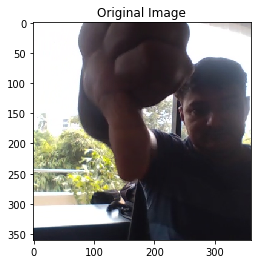

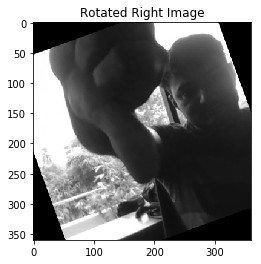

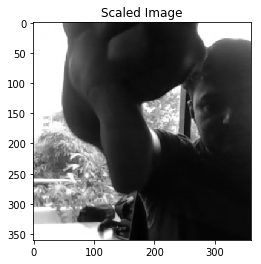

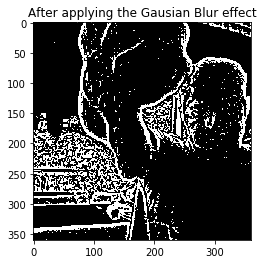

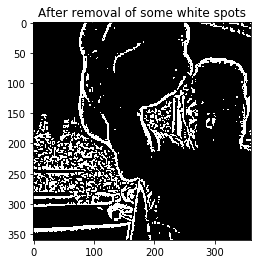

In [53]:
# To check some of the image how does it look
# Picked one image which having low brightness
# Some Data Augmentation Techniques
# Some of the images like below basically had issue with the brightness
# And as you can see in the image there are lot of noise in the background 

files_in_fold = glob.glob( './train/WIN_20180907_15_56_12_Pro_Thumbs Down_new' + '/*')
plt.imshow(imageio.imread(files_in_fold[15]))
plt.title('Original Image')
plt.show() 
# As it can be seen above in the above pics

img = imageio.imread(files_in_fold[15])
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
image = gray

# specify x and y coordinates to be used for shifting (mid points)
shift_x, shift_y = image.shape[0]/2, image.shape[1]/2

# translation by certain units
matrix_to_topleft = trans.SimilarityTransform(translation=[-shift_x, -shift_y])
matrix_to_center = trans.SimilarityTransform(translation=[shift_x, shift_y])

# rotation ( Rotation by 20 degrees)
rot_transforms =  trans.AffineTransform(rotation=np.deg2rad(20))
rot_matrix = matrix_to_topleft + rot_transforms + matrix_to_center
rot_image = trans.warp(image, rot_matrix)
plt.imshow(rot_image, cmap = 'gray')
plt.title('Rotated Right Image')
plt.show()

## scaling by Zooming in 0.8 and 0.8
scale_transforms = trans.AffineTransform(scale=(0.8, 0.8))
scale_matrix = matrix_to_topleft + scale_transforms + matrix_to_center
scale_image_zoom_out = trans.warp(image, scale_matrix)
plt.imshow(scale_image_zoom_out, cmap = 'gray')
plt.title('Scaled Image')
plt.show()

#  image in grayscale will be applied with a gaussian blur effect with adaptive threshold filter.
blur = cv2.GaussianBlur(gray,(1,1),0.5).astype('uint8')   
th3 = cv2.adaptiveThreshold(blur,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,cv2.THRESH_BINARY_INV,11,2)
plt.imshow(th3, cmap = 'gray')
plt.title('After applying the Gausian Blur effect')
plt.show()

# Then so as to identify the edge morphological transformation is performed
# Erosion is done, so as to shrink bright regions and enlarges dark regions
# Openning is erosion followed by dilation. Opening can remove small bright spots (i.e. “salt”) 
# and connect small dark cracks.
mask1 = cv2.erode(th3, cv2.getStructuringElement(cv2.MORPH_RECT,(1,1)), iterations = 3)
mask1 = cv2.morphologyEx(mask1, cv2.MORPH_OPEN, cv2.getStructuringElement(cv2.MORPH_RECT,(2,2)))

plt.imshow(mask1, cmap = 'gray')
plt.title('After removal of some white spots')
plt.show()

#### Conclusion:
- As it can be seen after the morphological transformation and the data augmentation of rotation and scaled. So that more information can be extracted from the image

In [2]:
# Creating an Abstract class this will hold hold the primary skeleton code that will 
# be inherited and implemented by different model class
class modelSkeleton(ABC):
    
    def set_dataset_directory(self):
        """
        This will set the Dataset Spefic Details
        """
        print("Setting the Dataset Specific Parameter")
        self.train_doc = np.random.permutation(open('train.csv').readlines())
        self.val_doc = np.random.permutation(open('val.csv').readlines())
        self.train_path = 'train'
        self.val_path = 'val'
        self.num_train_sequences = len(self.train_doc)
        print('# training sequences =', self.num_train_sequences)
        self.num_val_sequences = len(self.val_doc)
        print('# validation sequences =', self.num_val_sequences)
        
    
    def generator(self, source_path, folder_list, need_augmentation = False):
        """
        This method will generate the set of images that will be fed onto the Model
        """
        batch_size=self.batch_size
        print( 'Source path = ', source_path, '; batch size =', batch_size)
        #create a list of image numbers you want to use for a particular video
        img_idx = sorted(np.random.choice(range(self.total_frame_per_video), self.frame_ip, replace=False))

        while True:
            t = np.random.permutation(folder_list)
            num_batches = len(folder_list)//batch_size # calculate the number of batches
            for batch in range(num_batches): # we iterate over the number of batches
                yield self.processed_batch_data(img_idx, source_path, batch_size, batch, t, need_augmentation)
            
            #remaining data points which are left after full batches
            remaining_data_point_len = len(folder_list) % batch_size
            if remaining_data_point_len > 0:
                yield self.processed_batch_data(img_idx, source_path, batch_size, batch, t, need_augmentation, remaining_data_point_len)
                
    def normalized_image(self,img):
        """
        Normalizing the Image Pixel and Using the Percentile Approach so as to deal with Outliers
        """
        return (img - np.percentile(img,5))/(np.percentile(img,95) - np.percentile(img,5))
    
    def perf_rotation(self, image):
        """
        Here the Images will be rotated by 20 degree and it will be resized and normalized
        """
        # specify x and y coordinates to be used for shifting (mid points)
        shift_x, shift_y = image.shape[0]/2, image.shape[1]/2
        # translation by certain units
        matrix_to_topleft = trans.SimilarityTransform(translation=[-shift_x, -shift_y])
        matrix_to_center = trans.SimilarityTransform(translation=[shift_x, shift_y])

        # rotation ( Rotation by 20 degrees)
        rot_transforms =  trans.AffineTransform(rotation=np.deg2rad(20))
        rot_matrix = matrix_to_topleft + rot_transforms + matrix_to_center
        rot_image = trans.warp(image, rot_matrix)
        
        # Resizing of the image
        resized_image = imresize(rot_image,(self.height,self.width,self.channel))
        
        # Perform Normalization 
        return self.normalized_image(resized_image[:,:,0]),self.normalized_image(resized_image[:,:,1]), self.normalized_image(resized_image[:,:,2]) 
    
    def per_scaling(self, image):
        """
        Perform Scaling to the image 
        """
        # specify x and y coordinates to be used for shifting (mid points)
        shift_x, shift_y = image.shape[0]/2, image.shape[1]/2
        
        # translation by certain units
        matrix_to_topleft = trans.SimilarityTransform(translation=[-shift_x, -shift_y])
        matrix_to_center = trans.SimilarityTransform(translation=[shift_x, shift_y])
        
        scale_transforms = trans.AffineTransform(scale=(0.8, 0.8))
        scale_matrix = matrix_to_topleft + scale_transforms + matrix_to_center
        scale_image_zoom_out = trans.warp(image, scale_matrix)
        
        # Resizing of the image
        resized_image = imresize(scale_image_zoom_out,(self.height,self.width,self.channel))
        
        # Perform Normalization 
        return self.normalized_image(resized_image[:,:,0]),self.normalized_image(resized_image[:,:,1]), self.normalized_image(resized_image[:,:,2])         
    
    def morphological_transformation(self, image):
        """
        Then so as to identify the edge morphological transformation is performed
        Erosion is done, so as to shrink bright regions and enlarges dark regions
        Openning is erosion followed by dilation. Opening can remove small bright spots (i.e. “salt”) 
        and connect small dark cracks
        """
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        blur = cv2.GaussianBlur(image,(1,1),0.5).astype('uint8')   
        th3 = cv2.adaptiveThreshold(blur,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,cv2.THRESH_BINARY_INV,11,2)
        mask1 = cv2.erode(th3, cv2.getStructuringElement(cv2.MORPH_RECT,(1,1)), iterations = 3)
        mask1 = cv2.morphologyEx(mask1, cv2.MORPH_OPEN, cv2.getStructuringElement(cv2.MORPH_RECT,(2,2)))
        # Changing from 1 color channel to 3 color channel
        mask1 = cv2.cvtColor(mask1, cv2.COLOR_GRAY2BGR)
        # Resizing of the image
        resized_image = imresize(mask1,(self.height,self.width,self.channel))
        
        # Perform Normalization 
        return self.normalized_image(resized_image[:,:,0]),self.normalized_image(resized_image[:,:,1]), self.normalized_image(resized_image[:,:,2])
    
    def processed_batch_data(self,img_idx,source_path,batch_size, batch, t, need_augmentation, remaining_data_point_len = 0 ):
        """
        This method will get the images per batch and also do the Image Preprocessing
        1. Resizing 
        2. Normalization
        3. Morphological Transformation
        4. Data Augmentation
        5. One ot vector of the batch labels
        """
        
        # Remaining data points which are left after full batches
        # If the Number of Data point is Perfectly Divisble by Batch Size then there won't be any remaining data point
        # If not then there will be some remaining data point in the last batch, so as to make a sequence using those
        # Remaining Data point
        
        if remaining_data_point_len > 0:
            no_data_in_seq = remaining_data_point_len
        else:
            no_data_in_seq = batch_size
            
        batch_data = np.zeros((no_data_in_seq, len(img_idx), self.height, self.width, self.channel))
        batch_labels = np.zeros((no_data_in_seq,self.no_of_class))
        
        # If the data augmentation is required
        if need_augmentation :
            batch_scaled_data = np.zeros((no_data_in_seq, len(img_idx), self.height, self.width, self.channel))
            batch_rotated_data = np.zeros((no_data_in_seq, len(img_idx), self.height, self.width, self.channel))
            batch_morp_data = np.zeros((no_data_in_seq, len(img_idx), self.height, self.width, self.channel))
        
        # iterate over number of Folders
        for folder in range(no_data_in_seq):
            imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0])
            for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                #crop the images and resize them. Note that the images are of 2 different shape 
                #and the conv3D will throw error if the inputs in a batch have different shapes
                resized_image = imresize(image,(self.height,self.width,self.channel))
                
                batch_data[folder,idx,:,:,0] = self.normalized_image(resized_image[:,:,0]) #normalise and feed in the image
                batch_data[folder,idx,:,:,1] = self.normalized_image(resized_image[:,:,1]) #normalise and feed in the image
                batch_data[folder,idx,:,:,2] = self.normalized_image(resized_image[:,:,2]) #normalise and feed in the image
                
                if need_augmentation :
                    batch_rotated_data[folder,idx,:,:,0],batch_rotated_data[folder,idx,:,:,1],batch_rotated_data[folder,idx,:,:,2] = self.perf_rotation(image)
                    batch_scaled_data[folder,idx,:,:,0],batch_scaled_data[folder,idx,:,:,1],batch_scaled_data[folder,idx,:,:,2] = self.per_scaling(image)
                    batch_morp_data[folder,idx,:,:,0],batch_morp_data[folder,idx,:,:,1],batch_morp_data[folder,idx,:,:,2] = self.morphological_transformation(image)
            
            # Creating the one hot vector for the Labels
            batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
        
        if need_augmentation :
            batch_data=  np.concatenate([batch_data,batch_scaled_data, batch_rotated_data, batch_morp_data])
            batch_labels=np.concatenate([batch_labels,batch_labels, batch_labels, batch_labels])
            
        return(batch_data, batch_labels)
            
    def setting_conf(self, height, width, channel = 3, no_of_class = 5, total_frame_per_video = 15, 
                           frame_ip = 15, batch_size = 50, num_of_epochs = 2):
        """
        Setting The Image Specific Property
        Setting the model Specific Hyperparameter
        These are main set of parameters whose final value will be decided based on Trial and Error
        """
        self.height = height
        self.width = width
        self.channel = channel
        self.no_of_class = no_of_class
        self.total_frame_per_video = total_frame_per_video
        self.frame_ip = frame_ip
        self.batch_size = batch_size
        self.num_of_epochs = num_of_epochs
    
    def model_train(self, model, need_augmentation=False):
        """
         1. Generate the batch data for Train and Validation
         2. Generate the Model Path where the model will be stored
         3. Control the LR when the Validation loss hits plateau
         4. Determine the Number of data per epochs and in validation
        """
        #Let us create the train_generator and the val_generator which will be used in .fit_generator.
        train_generator = self.generator(self.train_path, self.train_doc, need_augmentation)
        val_generator = self.generator(self.val_path, self.val_doc)
        model_path = 'training_models'
        if not os.path.exists(model_path):
            os.mkdir(model_path)
        model_name = model_path + '/' + 'model_init' + '_' + str(datetime.datetime.now()).replace(' ','').replace(':','_') + '/'
        if not os.path.exists(model_name):
            os.mkdir(model_name)
        filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'
        checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)
        
        # Reduce learning rate when a metric has stopped improving.
        LR = ReduceLROnPlateau(monitor="val_loss", factor = 0.1, patience = 5 , min_lr=0.0001 )
        callbacks_list = [checkpoint, LR]
        
        if (self.num_train_sequences%self.batch_size) == 0:
            steps_per_epoch = int(self.num_train_sequences/self.batch_size)
        else:
            steps_per_epoch = (self.num_train_sequences//self.batch_size) + 1

        if (self.num_val_sequences%self.batch_size) == 0:
            validation_steps = int(self.num_val_sequences/self.batch_size)
        else:
            validation_steps = (self.num_val_sequences//self.batch_size) + 1        
        
        print(f'steps_per_epoch: {steps_per_epoch}')
        print(f'validation_steps: {validation_steps}')

        
        model_history = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=self.num_of_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)
        return model_history
    
    def plot_model_perf(self,model_history):
        """
         This will plot models performance ( loss and the accuracy)
        """
        fig, ax = plt.subplots(1, 2, figsize=(10,5))
        ax[0].plot(model_history.history['loss'])   
        ax[0].plot(model_history.history['val_loss'])
        ax[0].legend(['Train loss','Validation loss'])
        
        # https://keras.io/api/metrics/accuracy_metrics/#categoricalaccuracy-class
        ax[1].plot(model_history.history['categorical_accuracy'])   
        ax[1].plot(model_history.history['val_categorical_accuracy'])
        ax[1].legend(['Train Categorical Accuracy','Val Categorical Accuracy'])
        
    # In this method the actual code of different model will be available
    @abstractmethod
    def model_define(self):
        pass

In [4]:
class ModelConv(modelSkeleton):
    def model_define(self):
        """
        """
        model = Sequential()
        model.add(Conv3D(16, (3, 3, 3), padding='same',
                 input_shape=(self.frame_ip,self.height,self.width,self.channel)))
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        
        model.add(Flatten())
        model.add(Dense(16,activation='relu'))
        model.add(Dense(self.no_of_class,activation='softmax'))
        model.compile(optimizer=optimizers.Adam(), loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [5]:
# Check the data set dimensions when Augmentation is used
conv3d = ModelConv()
conv3d.set_dataset_directory()
conv3d.setting_conf(100,100)
g=conv3d.generator(conv3d.val_path,conv3d.val_doc, need_augmentation=True)
batch_data, batch_labels=next(g)
print("Batch Data Shape {}".format(batch_data.shape))
print("Batch Labels Shape {}".format(batch_labels.shape))

Setting the Dataset Specific Parameter
# training sequences = 663
# validation sequences = 100
Source path =  val ; batch size = 50
Batch Data Shape (200, 15, 100, 100, 3)
Batch Labels Shape (200, 5)


In [6]:
# To check the dimension of the Batch when augmentation is not being used
conv3d = ModelConv()
conv3d.set_dataset_directory()
conv3d.setting_conf(100,100)
g=conv3d.generator(conv3d.val_path,conv3d.val_doc)
batch_data, batch_labels=next(g)
print("Batch Data Shape {}".format(batch_data.shape))
print("Batch Labels Shape {}".format(batch_labels.shape))

Setting the Dataset Specific Parameter
# training sequences = 663
# validation sequences = 100
Source path =  val ; batch size = 50
Batch Data Shape (50, 15, 100, 100, 3)
Batch Labels Shape (50, 5)


#### Conclusion

*With Data Augmentation the dimensions are*
- Batch Data Shape (200, 15, 100, 100, 3)
- Batch Labels Shape (200, 5)

*Without Data Augmentation the dimensions are*
- Batch Data Shape (50, 15, 100, 100, 3)
- Batch Labels Shape (50, 5)

*Why the dimensions are different because on the main image we are doing three augmentation techniques*
- Rotation
- Scaling
- Morphological Transformation

In [7]:
# Seeing the One-Hot encoded vector
batch_labels[:5]

array([[0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1.]])

#### Checking generator function's sample output

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


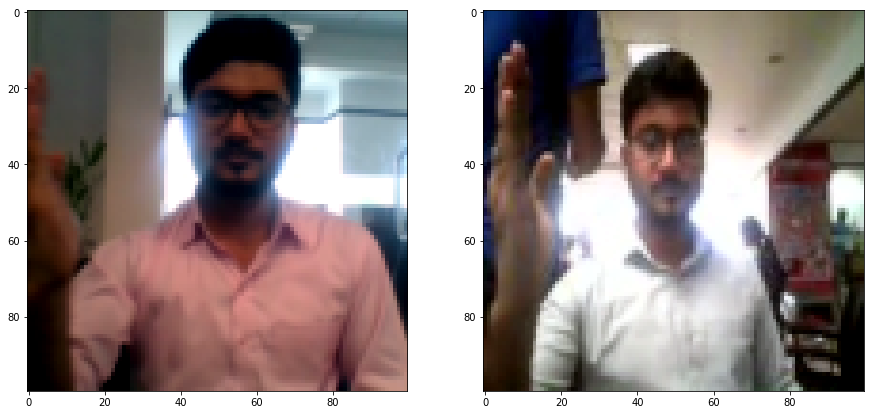

In [8]:
fig, ax = plt.subplots(1, 2, figsize = (15,15))
ax[0].imshow(batch_data[2,4,:,:,:])   
ax[1].imshow(batch_data[3,3,:,:,:])
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


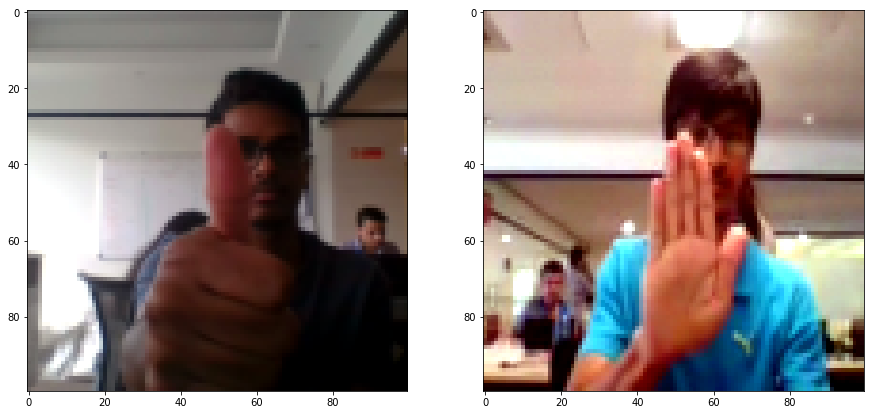

In [9]:
# To get the next iteration
batch_data, batch_labels=next(g)
fig, ax = plt.subplots(1, 2, figsize = (15,15))
ax[0].imshow(batch_data[2,4,:,:,:])   
ax[1].imshow(batch_data[3,3,:,:,:])
plt.show()

In [10]:
if os.path.isfile('movie.gif'):
   os.remove('movie.gif')
else:    
   print("File doesn't exists!") 
images = []
for data in range(batch_data.shape[1]):
   images.append(batch_data[15,data,:,:,:])
imageio.mimsave('movie.gif', images)
from IPython import display
display.HTML('<img src="{}"height="200" width="200">'.format('movie.gif'))

### Ablation
Checking whether the model training is working with and without augmentation

In [11]:
conv3d = ModelConv()
conv3d.set_dataset_directory()
conv3d.setting_conf(100,100)
conv3d_model=conv3d.model_define()
conv3d_model.summary()

Setting the Dataset Specific Parameter
# training sequences = 663
# validation sequences = 100
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_1 (Conv3D)            (None, 15, 100, 100, 16)  1312      
_________________________________________________________________
max_pooling3d_1 (MaxPooling3 (None, 7, 50, 50, 16)     0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 280000)            0         
_________________________________________________________________
dense_1 (Dense)              (None, 16)                4480016   
_________________________________________________________________
dense_2 (Dense)              (None, 5)                 85        
Total params: 4,481,413
Trainable params: 4,481,413
Non-trainable params: 0
_________________________________________________________________


In [12]:
model_1 = conv3d.model_train(conv3d_model)

steps_per_epoch: 14
validation_steps: 2
Source path =  val ; batch size = 50
Source path =  train ; batch size = 50
Epoch 1/2
14/14 [==============================] - 72s 5s/step - loss: 12.1824 - categorical_accuracy: 0.1988 - val_loss: 12.7333 - val_categorical_accuracy: 0.2100

Epoch 00001: saving model to training_models/model_init_2020-05-2217_51_13.354361/model-00001-12.04248-0.20513-12.73329-0.21000.h5
Epoch 2/2
14/14 [==============================] - 54s 4s/step - loss: 12.6609 - categorical_accuracy: 0.2145 - val_loss: 12.7333 - val_categorical_accuracy: 0.2100

Epoch 00002: saving model to training_models/model_init_2020-05-2217_51_13.354361/model-00002-12.73889-0.20965-12.73330-0.21000.h5


In [13]:
model_1 = conv3d.model_train(conv3d_model, need_augmentation=True)

steps_per_epoch: 14
validation_steps: 2
Source path =  val ; batch size = 50
Source path =  train Epoch 1/2
; batch size = 50
14/14 [==============================] - 279s 20s/step - loss: 12.9831 - categorical_accuracy: 0.1945 - val_loss: 12.7333 - val_categorical_accuracy: 0.2100

Epoch 00001: saving model to training_models/model_init_2020-05-2217_53_25.733209/model-00001-12.88475-0.20060-12.73330-0.21000.h5
Epoch 2/2
14/14 [==============================] - 267s 19s/step - loss: 12.8675 - categorical_accuracy: 0.2017 - val_loss: 12.7333 - val_categorical_accuracy: 0.2100

Epoch 00002: saving model to training_models/model_init_2020-05-2217_53_25.733209/model-00002-12.76320-0.20814-12.73329-0.21000.h5


#### Running same ablation experiment with higher resolution

In [14]:
conv3d = ModelConv()
conv3d.set_dataset_directory()
conv3d.setting_conf(150,150)
conv3d_model=conv3d.model_define()
conv3d_model.summary()

Setting the Dataset Specific Parameter
# training sequences = 663
# validation sequences = 100
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_2 (Conv3D)            (None, 15, 150, 150, 16)  1312      
_________________________________________________________________
max_pooling3d_2 (MaxPooling3 (None, 7, 75, 75, 16)     0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 630000)            0         
_________________________________________________________________
dense_3 (Dense)              (None, 16)                10080016  
_________________________________________________________________
dense_4 (Dense)              (None, 5)                 85        
Total params: 10,081,413
Trainable params: 10,081,413
Non-trainable params: 0
_________________________________________________________________


In [15]:
model_1 = conv3d.model_train(conv3d_model)

steps_per_epoch: 14
validation_steps: 2
Source path =  val ; batch size = 50
Source path =  train ; batch size = 50
Epoch 1/2
14/14 [==============================] - 82s 6s/step - loss: 12.0135 - categorical_accuracy: 0.2093 - val_loss: 12.4109 - val_categorical_accuracy: 0.2300

Epoch 00001: saving model to training_models/model_init_2020-05-2218_02_54.895983/model-00001-11.99349-0.20814-12.41093-0.23000.h5
Epoch 2/2
14/14 [==============================] - 65s 5s/step - loss: 12.9369 - categorical_accuracy: 0.1974 - val_loss: 12.4109 - val_categorical_accuracy: 0.2300

Epoch 00002: saving model to training_models/model_init_2020-05-2218_02_54.895983/model-00002-12.83613-0.20362-12.41093-0.23000.h5


#### Conclusion:
- As we are increasing size of the image e.g., from (100,100) to (150,150), the number of trainable parameters become more than double, as well as processing took more time thereby increasing the computation time significantly.
- To save computation time on the further models, we'd select smaller image size i.e., (100,100)

### Model_1 (CNN 3D) - Simple Model with three Conv3D and Dense Layers

In [16]:
class Model_CNN1(modelSkeleton):
    def model_define(self):
        """
        Started with less complex model with a smaller number of layers without 
        any Regularization or Batch Normalization that results in overfitting.
        """
        model = Sequential()
        model.add(Conv3D(8, kernel_size=(3, 3, 3), padding='same', 
                 input_shape=(self.frame_ip,self.height,self.width,self.channel),activation='relu'))
        model.add(MaxPooling3D(pool_size=(2, 2, 2), padding='same'))
        model.add(Conv3D(16, kernel_size=(2, 2, 2), padding='same',activation='relu'))
        model.add(MaxPooling3D(pool_size=(2, 2, 2), padding='same'))
        model.add(Conv3D(32, kernel_size=(2, 2, 2), padding='same',activation='relu'))
        model.add(MaxPooling3D(pool_size=(2, 2, 2), padding='same'))
        
        
        model.add(Flatten())
        model.add(Dense(64,activation='relu'))
        model.add(Dense(32,activation='relu'))
        model.add(Dense(16,activation='relu'))
        model.add(Dense(self.no_of_class,activation='softmax'))
        
        model.compile(optimizer=optimizers.Adam(), loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [17]:
conv3d_1 = Model_CNN1()
conv3d_1.set_dataset_directory()
conv3d_1.setting_conf(100,100, total_frame_per_video = 30, 
                           frame_ip = 20, batch_size = 30, num_of_epochs = 10)
conv3d_1_model = conv3d_1.model_define()
conv3d_1_model.summary()

model_2 = conv3d_1.model_train(conv3d_1_model)

Setting the Dataset Specific Parameter
# training sequences = 663
# validation sequences = 100
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_3 (Conv3D)            (None, 20, 100, 100, 8)   656       
_________________________________________________________________
max_pooling3d_3 (MaxPooling3 (None, 10, 50, 50, 8)     0         
_________________________________________________________________
conv3d_4 (Conv3D)            (None, 10, 50, 50, 16)    1040      
_________________________________________________________________
max_pooling3d_4 (MaxPooling3 (None, 5, 25, 25, 16)     0         
_________________________________________________________________
conv3d_5 (Conv3D)            (None, 5, 25, 25, 32)     4128      
_________________________________________________________________
max_pooling3d_5 (MaxPooling3 (None, 3, 13, 13, 32)     0         
_______________________________________________

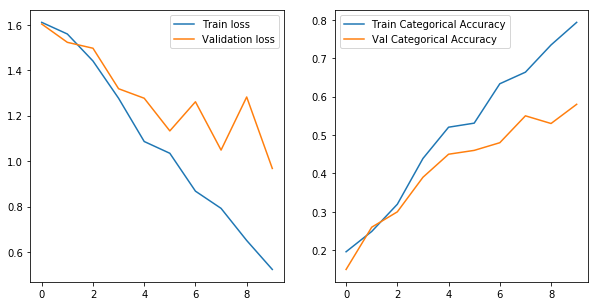

In [18]:
conv3d_1.plot_model_perf(model_2)

#### Conclusion:
- As we can see from the above plot, validation loss is much higher than train loss as well as validation accuracy is much smaller than training accuracy, it can be said that model is overfitting.
- To deal with it, we'll add drop out and batch normalisation to regularise parameters in the next model.

### Model_2 (CNN 3D) ( Adding Regularization and Dropout )

In [19]:
class Model_CNN2(modelSkeleton):
    def model_define(self):
        """
        Adding regularization layers, Batch Normalizations and Dropout 
        Batch Normalizations are added after each conv layer and Dropout is added after pooling layer
        """
        model = Sequential()
        model.add(Conv3D(8, kernel_size=(3, 3, 3), padding='same', 
                 input_shape=(self.frame_ip,self.height,self.width,self.channel),activation='relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2), padding='same'))
        model.add(Dropout(0.25))
        
        model.add(Conv3D(16, kernel_size=(2, 2, 2), padding='same',activation='relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2), padding='same'))
        model.add(Dropout(0.25))
        
        model.add(Conv3D(32, kernel_size=(2, 2, 2), padding='same',activation='relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2), padding='same'))
        model.add(Dropout(0.25))
                
        model.add(Flatten())
        model.add(Dense(64,activation='relu'))
        model.add(Dense(32,activation='relu'))
        model.add(Dense(16,activation='relu'))
        model.add(Dense(self.no_of_class,activation='softmax'))
        
        model.compile(optimizer=optimizers.Adam(), loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [20]:
conv3d_2 = Model_CNN2()
conv3d_2.set_dataset_directory()
conv3d_2.setting_conf(100,100, total_frame_per_video = 30, 
                           frame_ip = 20, batch_size = 30, num_of_epochs = 10)
conv3d_2_model = conv3d_2.model_define()
conv3d_2_model.summary()

model_3 = conv3d_2.model_train(conv3d_2_model)

Setting the Dataset Specific Parameter
# training sequences = 663
# validation sequences = 100
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_6 (Conv3D)            (None, 20, 100, 100, 8)   656       
_________________________________________________________________
batch_normalization_1 (Batch (None, 20, 100, 100, 8)   32        
_________________________________________________________________
max_pooling3d_6 (MaxPooling3 (None, 10, 50, 50, 8)     0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 10, 50, 50, 8)     0         
_________________________________________________________________
conv3d_7 (Conv3D)            (None, 10, 50, 50, 16)    1040      
_________________________________________________________________
batch_normalization_2 (Batch (None, 10, 50, 50, 16)    64        
_______________________________________________

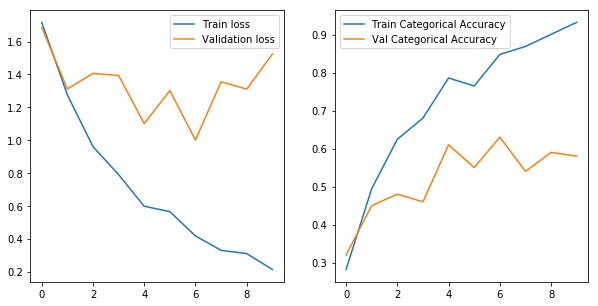

In [21]:
conv3d_2.plot_model_perf(model_3)

#### Conclusion:
- As we can see from the above plot, validation loss is much higher than train loss as well as validation accuracy is much smaller than training accuracy, it can be said that model is overfitting.
- Irrespective of adding regularization layers the model performance didn't improved a lot

### Model 3  (CNN 3D) Adding More Layers + Increasing Kernel Size and removing Dropout after each Conv Layer

In [22]:
class Model_CNN3(modelSkeleton):
    def model_define(self):
        """
        Increasing number of Convolution layers +  Dense Layers
        and also adding dropout at the last layer
        and also increased the kernel size
        and this will decrease the number of trainable parameter
        """
        model = Sequential()
        model.add(Conv3D(8, kernel_size=(3, 3, 3), padding='same', 
                 input_shape=(self.frame_ip,self.height,self.width,self.channel),activation='relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2), padding='same'))
        
        model.add(Conv3D(16, kernel_size=(3, 3, 3), padding='same',activation='relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2), padding='same'))
        
        model.add(Conv3D(32, kernel_size=(3, 3, 3), padding='same',activation='relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2), padding='same'))
        
        model.add(Conv3D(64, kernel_size=(3, 3, 3), padding='same',activation='relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2), padding='same'))
        
        model.add(Conv3D(128, kernel_size=(3, 3, 3), padding='same',activation='relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2), padding='same'))
        model.add(Dropout(0.25))
        
                
        model.add(Flatten())
        model.add(Dense(128,activation='relu'))
        model.add(Dense(64,activation='relu'))
        model.add(Dense(32,activation='relu'))
        model.add(Dense(self.no_of_class,activation='softmax'))
        
        model.compile(optimizer=optimizers.Adam(), loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [23]:
# Increasing the batch size
conv3d_3 = Model_CNN3()
conv3d_3.set_dataset_directory()
conv3d_3.setting_conf(100,100, total_frame_per_video = 30, 
                           frame_ip = 20, batch_size = 50, num_of_epochs = 10)
conv3d_3_model = conv3d_3.model_define()
conv3d_3_model.summary()

model_4 = conv3d_3.model_train(conv3d_3_model)

Setting the Dataset Specific Parameter
# training sequences = 663
# validation sequences = 100
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_9 (Conv3D)            (None, 20, 100, 100, 8)   656       
_________________________________________________________________
batch_normalization_4 (Batch (None, 20, 100, 100, 8)   32        
_________________________________________________________________
max_pooling3d_9 (MaxPooling3 (None, 10, 50, 50, 8)     0         
_________________________________________________________________
conv3d_10 (Conv3D)           (None, 10, 50, 50, 16)    3472      
_________________________________________________________________
batch_normalization_5 (Batch (None, 10, 50, 50, 16)    64        
_________________________________________________________________
max_pooling3d_10 (MaxPooling (None, 5, 25, 25, 16)     0         
_______________________________________________

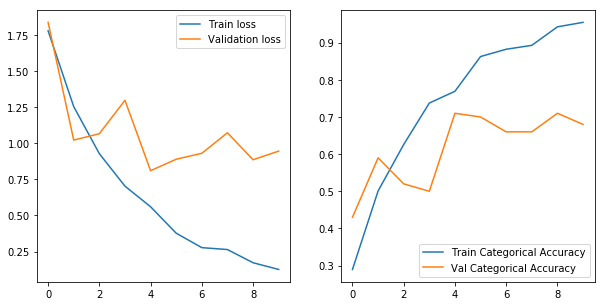

In [24]:
conv3d_3.plot_model_perf(model_4)

#### Conclusion:
- As we can see from the above plot, validation loss is not much higher than train loss as well as validation accuracy is smaller than training accuracy, it can be said that model is overfitting.
- But as it can be seen in term of model performance this is the best model till now in terms of loss and accuracy, lets try to fine tune the model

### Model 4  (CNN 3D) Adding Regularizations after each layer to overcome Overfitting

In [25]:
class Model_CNN4(modelSkeleton):
    def model_define(self):
        """
        Adding dropout to each layer so that model shouldn't be overfitting 
        """
        model = Sequential()
        model.add(Conv3D(8, kernel_size=(3, 3, 3), padding='same', 
                 input_shape=(self.frame_ip,self.height,self.width,self.channel),activation='relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2), padding='same'))
        model.add(Dropout(0.25))
        
        model.add(Conv3D(16, kernel_size=(3, 3, 3), padding='same',activation='relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2), padding='same'))
        model.add(Dropout(0.25))
        
        model.add(Conv3D(32, kernel_size=(3, 3, 3), padding='same',activation='relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2), padding='same'))
        model.add(Dropout(0.25))
        
        model.add(Conv3D(64, kernel_size=(3, 3, 3), padding='same',activation='relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2), padding='same'))
        model.add(Dropout(0.25))
        
        model.add(Conv3D(128, kernel_size=(3, 3, 3), padding='same',activation='relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2), padding='same'))
        model.add(Dropout(0.25))
        
                
        model.add(Flatten())
        model.add(Dense(128,activation='relu'))
        model.add(Dropout(0.25))
        model.add(Dense(64,activation='relu'))
        model.add(Dropout(0.25))
        model.add(Dense(32,activation='relu'))
        model.add(Dropout(0.25))
        model.add(Dense(self.no_of_class,activation='softmax'))
        
        model.compile(optimizer=optimizers.Adam(), loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [26]:
# Increasing the batch size
conv3d_4 = Model_CNN4()
conv3d_4.set_dataset_directory()
conv3d_4.setting_conf(100,100, total_frame_per_video = 30, 
                           frame_ip = 20, batch_size = 50, num_of_epochs = 10)
conv3d_4_model = conv3d_4.model_define()
conv3d_4_model.summary()

model_5 = conv3d_4.model_train(conv3d_4_model)

Setting the Dataset Specific Parameter
# training sequences = 663
# validation sequences = 100
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_14 (Conv3D)           (None, 20, 100, 100, 8)   656       
_________________________________________________________________
batch_normalization_9 (Batch (None, 20, 100, 100, 8)   32        
_________________________________________________________________
max_pooling3d_14 (MaxPooling (None, 10, 50, 50, 8)     0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 10, 50, 50, 8)     0         
_________________________________________________________________
conv3d_15 (Conv3D)           (None, 10, 50, 50, 16)    3472      
_________________________________________________________________
batch_normalization_10 (Batc (None, 10, 50, 50, 16)    64        
_______________________________________________

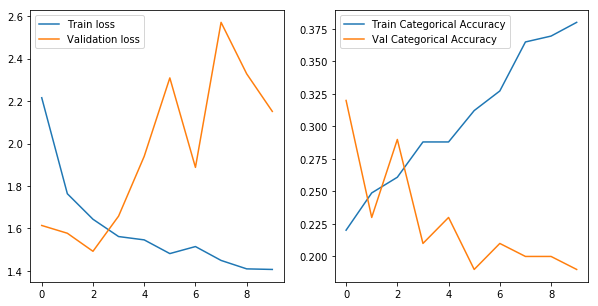

In [27]:
conv3d_4.plot_model_perf(model_5)

#### Conclusion:
- As we can see from the above plot, validation loss is much higher than train loss as well as validation accuracy is way smaller than training accuracy, it can be said that model is not learning much 
- Because of the excessive regularizations, the model is not learning at all.

### Model 5  (CNN 3D) ( Removed Dropout after each Conv Layer + Batch Norm prior to Activation )

In [28]:
class Model_CNN5(modelSkeleton):
    def model_define(self):
        """
        As it can be seen from other model, because of too many dropouts the learning ability of the model reduced a lot
        Hence removing the dropouts after each layer and also adding batch normalization prior to applying activation
        """
        model = Sequential()
        model.add(Conv3D(8, kernel_size=(3, 3, 3), padding='same', 
                 input_shape=(self.frame_ip,self.height,self.width,self.channel)))
        model.add(BatchNormalization())
        model.add(Activation(activations.relu))
        model.add(MaxPooling3D(pool_size=(2, 2, 2), padding='same'))
        
        model.add(Conv3D(16, kernel_size=(3, 3, 3), padding='same'))
        model.add(BatchNormalization())
        model.add(Activation(activations.relu))
        model.add(MaxPooling3D(pool_size=(2, 2, 2), padding='same'))
        
        model.add(Conv3D(32, kernel_size=(3, 3, 3), padding='same'))
        model.add(BatchNormalization())
        model.add(Activation(activations.relu))
        model.add(MaxPooling3D(pool_size=(2, 2, 2), padding='same'))
        
        model.add(Conv3D(64, kernel_size=(3, 3, 3), padding='same'))
        model.add(BatchNormalization())
        model.add(Activation(activations.relu))
        model.add(MaxPooling3D(pool_size=(2, 2, 2), padding='same'))
        
        model.add(Conv3D(128, kernel_size=(3, 3, 3), padding='same'))
        model.add(BatchNormalization())
        model.add(Activation(activations.relu))
        model.add(MaxPooling3D(pool_size=(2, 2, 2), padding='same'))
        model.add(Dropout(0.25))
        
                
        model.add(Flatten())
        model.add(Dense(128,activation='relu'))
        model.add(Dense(64,activation='relu'))
        model.add(Dense(32,activation='relu'))
        model.add(Dense(self.no_of_class,activation='softmax'))
        
        model.compile(optimizer=optimizers.Adam(), loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [29]:
# Increasing the batch size
conv3d_5 = Model_CNN5()
conv3d_5.set_dataset_directory()
conv3d_5.setting_conf(100,100, total_frame_per_video = 30, 
                           frame_ip = 20, batch_size = 50, num_of_epochs = 10)
conv3d_5_model = conv3d_5.model_define()
conv3d_5_model.summary()

model_6 = conv3d_5.model_train(conv3d_5_model)

Setting the Dataset Specific Parameter
# training sequences = 663
# validation sequences = 100
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_19 (Conv3D)           (None, 20, 100, 100, 8)   656       
_________________________________________________________________
batch_normalization_14 (Batc (None, 20, 100, 100, 8)   32        
_________________________________________________________________
activation_1 (Activation)    (None, 20, 100, 100, 8)   0         
_________________________________________________________________
max_pooling3d_19 (MaxPooling (None, 10, 50, 50, 8)     0         
_________________________________________________________________
conv3d_20 (Conv3D)           (None, 10, 50, 50, 16)    3472      
_________________________________________________________________
batch_normalization_15 (Batc (None, 10, 50, 50, 16)    64        
_______________________________________________

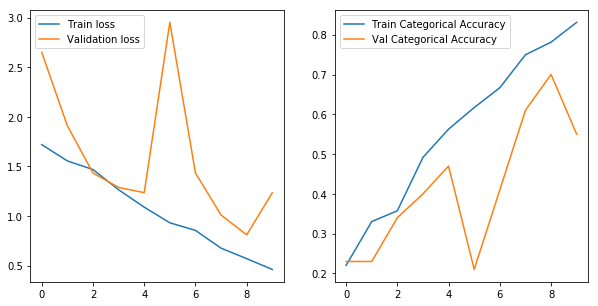

In [30]:
conv3d_5.plot_model_perf(model_6)

#### Conclusion:
- As we can see from the above plot, validation loss is higher than train loss as well as validation accuracy is way smaller than training accuracy, it can be said that model is overfitting a lot.
- But as it can be seen in term of model performance, the model has overfitted a lot and reducing the regularization lead to this fact

### Model 6  (CNN 3D) ( Increased Number of Convolution Layer )

In [31]:
class Model_CNN6(modelSkeleton):
    def model_define(self):
        """
        Increasing the number of Convolution Layers
        """
        model = Sequential()
        model.add(Conv3D(32, kernel_size=(3, 3, 3), padding='same', 
                 input_shape=(self.frame_ip,self.height,self.width,self.channel)))
        model.add(BatchNormalization())
        model.add(Activation(activations.relu))
        model.add(MaxPooling3D(pool_size=(2, 2, 2), padding='same'))
        
        model.add(Conv3D(64, kernel_size=(3, 3, 3), padding='same'))
        model.add(BatchNormalization())
        model.add(Activation(activations.relu))
        model.add(MaxPooling3D(pool_size=(2, 2, 2), padding='same'))
        
        model.add(Conv3D(128, kernel_size=(3, 3, 3), padding='same'))
        model.add(BatchNormalization())
        model.add(Activation(activations.relu))
        model.add(MaxPooling3D(pool_size=(2, 2, 2), padding='same'))
        
        model.add(Conv3D(256, kernel_size=(3, 3, 3), padding='same'))
        model.add(BatchNormalization())
        model.add(Activation(activations.relu))
        model.add(Dropout(0.25))
        model.add(MaxPooling3D(pool_size=(2, 2, 2), padding='same'))
        
                
        model.add(Flatten())
        model.add(Dense(128,activation='relu'))
        model.add(Dense(64,activation='relu'))
        model.add(Dense(self.no_of_class,activation='softmax'))
        
        model.compile(optimizer=optimizers.Adam(), loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [32]:
# Increasing the batch size
conv3d_6 = Model_CNN6()
conv3d_6.set_dataset_directory()
conv3d_6.setting_conf(100,100, total_frame_per_video = 30, 
                           frame_ip = 20, batch_size = 50, num_of_epochs = 10)
conv3d_6_model = conv3d_6.model_define()
conv3d_6_model.summary()

model_7 = conv3d_6.model_train(conv3d_6_model)

Setting the Dataset Specific Parameter
# training sequences = 663
# validation sequences = 100
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_24 (Conv3D)           (None, 20, 100, 100, 32)  2624      
_________________________________________________________________
batch_normalization_19 (Batc (None, 20, 100, 100, 32)  128       
_________________________________________________________________
activation_6 (Activation)    (None, 20, 100, 100, 32)  0         
_________________________________________________________________
max_pooling3d_24 (MaxPooling (None, 10, 50, 50, 32)    0         
_________________________________________________________________
conv3d_25 (Conv3D)           (None, 10, 50, 50, 64)    55360     
_________________________________________________________________
batch_normalization_20 (Batc (None, 10, 50, 50, 64)    256       
_______________________________________________

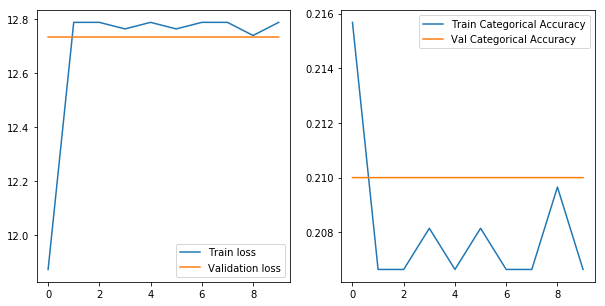

In [33]:
conv3d_6.plot_model_perf(model_7)

#### Conclusion:
- As we can see from the above plot, validation loss is not much higher than train loss as well as validation accuracy is smaller than training accuracy, but the model is not learning much.

### Model 7  (CNN 3D) ( Decreasing the Kernel Size in Conv Layer except the First Layer )

In [34]:
class Model_CNN7(modelSkeleton):
    def model_define(self):
        """
        In the subsequent Convolution Layers the filter is reduced, so as a result number of parameters also increased
        """
        model = Sequential()
        model.add(Conv3D(32, kernel_size=(3, 3, 3), padding='same', 
                 input_shape=(self.frame_ip,self.height,self.width,self.channel)))
        model.add(BatchNormalization())
        model.add(Activation(activations.relu))
        model.add(MaxPooling3D(pool_size=(2, 2, 2), padding='same'))
        
        model.add(Conv3D(64, kernel_size=(2, 2, 2), padding='same'))
        model.add(BatchNormalization())
        model.add(Activation(activations.relu))
        model.add(MaxPooling3D(pool_size=(2, 2, 2), padding='same'))
        
        model.add(Conv3D(128, kernel_size=(2, 2, 2), padding='same'))
        model.add(BatchNormalization())
        model.add(Activation(activations.relu))
        model.add(MaxPooling3D(pool_size=(2, 2, 2), padding='same'))
        model.add(Dropout(0.25))
        
                
        model.add(Flatten())
        model.add(Dense(128,activation='relu'))
        model.add(Dense(64,activation='relu'))
        model.add(Dense(self.no_of_class,activation='softmax'))
        
        model.compile(optimizer=optimizers.Adam(), loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [35]:
# Increasing the batch size
conv3d_7 = Model_CNN7()
conv3d_7.set_dataset_directory()
conv3d_7.setting_conf(100,100, total_frame_per_video = 30, 
                           frame_ip = 20, batch_size = 50, num_of_epochs = 10)
conv3d_7_model = conv3d_7.model_define()
conv3d_7_model.summary()

model_8 = conv3d_7.model_train(conv3d_7_model)

Setting the Dataset Specific Parameter
# training sequences = 663
# validation sequences = 100
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_28 (Conv3D)           (None, 20, 100, 100, 32)  2624      
_________________________________________________________________
batch_normalization_23 (Batc (None, 20, 100, 100, 32)  128       
_________________________________________________________________
activation_10 (Activation)   (None, 20, 100, 100, 32)  0         
_________________________________________________________________
max_pooling3d_28 (MaxPooling (None, 10, 50, 50, 32)    0         
_________________________________________________________________
conv3d_29 (Conv3D)           (None, 10, 50, 50, 64)    16448     
_________________________________________________________________
batch_normalization_24 (Batc (None, 10, 50, 50, 64)    256       
_______________________________________________

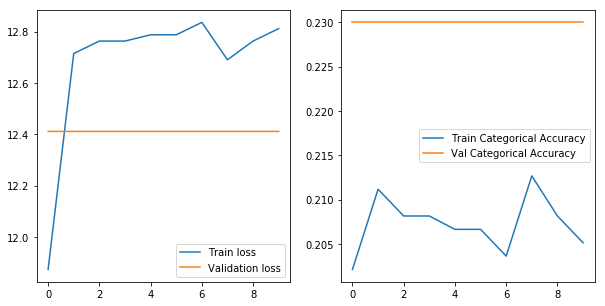

In [36]:
conv3d_7.plot_model_perf(model_8)

#### Conclusion:
- As we can see from the above plot, validation loss is linear and validation accuracy  is not at all improving, it can be seen as well, training accuracy is improving as well as the loss is not decreasing hence the model is not improving at all, i.e. Model is not learning at all

### Model 8  (CNN 3D) (Adding Conv Layer with less Feature Maps + Low Kernel Size + Regularization in Dense Layer)

In [37]:
class Model_CNN8(modelSkeleton):
    def model_define(self):
        """
        Adding convolution layer with less Feature Maps, kernel size was reduced &
        Batch Normalization added between each dense layer
        """
        model = Sequential()
        
        model.add(Conv3D(16, kernel_size=(2, 2, 2), padding='same', 
                 input_shape=(self.frame_ip,self.height,self.width,self.channel)))
        model.add(BatchNormalization())
        model.add(Activation(activations.relu))
        model.add(MaxPooling3D(pool_size=(2, 2, 2), padding='same'))
        
        model.add(Conv3D(32, kernel_size=(2, 2, 2), padding='same'))
        model.add(BatchNormalization())
        model.add(Activation(activations.relu))
        model.add(MaxPooling3D(pool_size=(2, 2, 2), padding='same'))
        
        model.add(Conv3D(64, kernel_size=(2, 2, 2), padding='same'))
        model.add(BatchNormalization())
        model.add(Activation(activations.relu))
        model.add(MaxPooling3D(pool_size=(2, 2, 2), padding='same'))
        
        model.add(Conv3D(128, kernel_size=(2, 2, 2), padding='same'))
        model.add(BatchNormalization())
        model.add(Activation(activations.relu))
        model.add(MaxPooling3D(pool_size=(2, 2, 2), padding='same'))
        
                
        model.add(Flatten())
        model.add(Dense(128,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dense(64,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dense(self.no_of_class,activation='softmax'))
        
        model.compile(optimizer=optimizers.Adam(), loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [39]:
# Increasing the batch size
conv3d_8 = Model_CNN8()
conv3d_8.set_dataset_directory()
conv3d_8.setting_conf(100,100, total_frame_per_video = 30, 
                           frame_ip = 15, batch_size = 50, num_of_epochs = 10)
conv3d_8_model = conv3d_8.model_define()
conv3d_8_model.summary()

model_9 = conv3d_8.model_train(conv3d_8_model)

Setting the Dataset Specific Parameter
# training sequences = 663
# validation sequences = 100
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_35 (Conv3D)           (None, 15, 100, 100, 16)  400       
_________________________________________________________________
batch_normalization_32 (Batc (None, 15, 100, 100, 16)  64        
_________________________________________________________________
activation_17 (Activation)   (None, 15, 100, 100, 16)  0         
_________________________________________________________________
max_pooling3d_35 (MaxPooling (None, 8, 50, 50, 16)     0         
_________________________________________________________________
conv3d_36 (Conv3D)           (None, 8, 50, 50, 32)     4128      
_________________________________________________________________
batch_normalization_33 (Batc (None, 8, 50, 50, 32)     128       
_______________________________________________

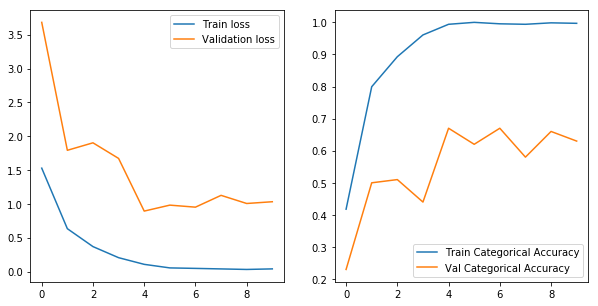

In [40]:
conv3d_8.plot_model_perf(model_9)

#### Conclusion:
- As we can see from the above plot, validation loss is much higher than train loss as well as validation accuracy is way smaller than training accuracy, it can be said that model is overfitting a lot, its a very complex model
- But as it can be seen in term of model performance, the model has overfitted a lot lets try to add some dropout layers

### Model 9  (CNN 3D)( Removing Batch Normalization and adding Dropout Layers in Dense Layer + Increasing Batch Size)

In [41]:
class Model_CNN9(modelSkeleton):
    def model_define(self):
        """
        Removed Batch Normalization and added Dropout in the dense layer with Augmentation
        """
        model = Sequential()
        model.add(Conv3D(16, kernel_size=(2, 2, 2), padding='same', 
                 input_shape=(self.frame_ip,self.height,self.width,self.channel)))
        model.add(BatchNormalization())
        model.add(Activation(activations.relu))
        model.add(MaxPooling3D(pool_size=(2, 2, 2), padding='same'))
        
        model.add(Conv3D(32, kernel_size=(2, 2, 2), padding='same'))
        model.add(BatchNormalization())
        model.add(Activation(activations.relu))
        model.add(MaxPooling3D(pool_size=(2, 2, 2), padding='same'))
        
        model.add(Conv3D(64, kernel_size=(2, 2, 2), padding='same'))
        model.add(BatchNormalization())
        model.add(Activation(activations.relu))
        model.add(MaxPooling3D(pool_size=(2, 2, 2), padding='same'))
        
        model.add(Conv3D(128, kernel_size=(2, 2, 2), padding='same'))
        model.add(BatchNormalization())
        model.add(Activation(activations.relu))
        model.add(MaxPooling3D(pool_size=(2, 2, 2), padding='same'))
        
                
        model.add(Flatten())
        model.add(Dense(128,activation='relu'))
        model.add(Dense(64,activation='relu'))
        model.add(Dropout(0.25))
        model.add(Dense(self.no_of_class,activation='softmax'))
        
        model.compile(optimizer=optimizers.Adam(), loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [42]:
# Increasing the batch size
conv3d_9 = Model_CNN9()
conv3d_9.set_dataset_directory()
conv3d_9.setting_conf(100,100, total_frame_per_video = 30, 
                           frame_ip = 25, batch_size = 30, num_of_epochs = 20)
conv3d_9_model = conv3d_9.model_define()
conv3d_9_model.summary()

model_10 = conv3d_9.model_train(conv3d_9_model)

Setting the Dataset Specific Parameter
# training sequences = 663
# validation sequences = 100
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_39 (Conv3D)           (None, 25, 100, 100, 16)  400       
_________________________________________________________________
batch_normalization_38 (Batc (None, 25, 100, 100, 16)  64        
_________________________________________________________________
activation_21 (Activation)   (None, 25, 100, 100, 16)  0         
_________________________________________________________________
max_pooling3d_39 (MaxPooling (None, 13, 50, 50, 16)    0         
_________________________________________________________________
conv3d_40 (Conv3D)           (None, 13, 50, 50, 32)    4128      
_________________________________________________________________
batch_normalization_39 (Batc (None, 13, 50, 50, 32)    128       
_______________________________________________


Epoch 00017: saving model to training_models/model_init_2020-05-2219_54_47.008705/model-00017-0.15006-0.95777-0.68699-0.75000.h5
Epoch 18/20
23/23 [==============================] - 84s 4s/step - loss: 0.1343 - categorical_accuracy: 0.9681 - val_loss: 0.7498 - val_categorical_accuracy: 0.7200

Epoch 00018: saving model to training_models/model_init_2020-05-2219_54_47.008705/model-00018-0.13758-0.96682-0.74977-0.72000.h5
Epoch 19/20
23/23 [==============================] - 84s 4s/step - loss: 0.1334 - categorical_accuracy: 0.9594 - val_loss: 0.7143 - val_categorical_accuracy: 0.7100

Epoch 00019: saving model to training_models/model_init_2020-05-2219_54_47.008705/model-00019-0.13732-0.95777-0.71428-0.71000.h5
Epoch 20/20
23/23 [==============================] - 83s 4s/step - loss: 0.1337 - categorical_accuracy: 0.9599 - val_loss: 0.6125 - val_categorical_accuracy: 0.7900

Epoch 00020: saving model to training_models/model_init_2020-05-2219_54_47.008705/model-00020-0.11435-0.97134-0.61

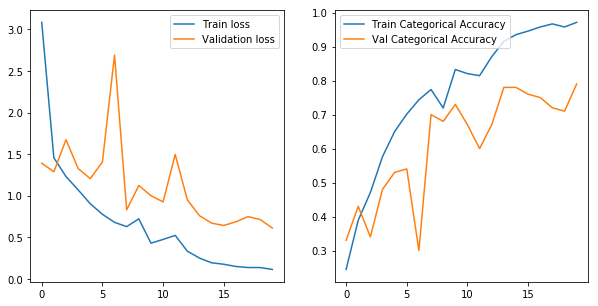

In [43]:
conv3d_9.plot_model_perf(model_10)

#### Conclusion:
- As we can see from the above plot, validation loss is nearly same like the train loss as well as validation accuracy is very close to training accuracy, it can be said that model is learning as well as validation is working fine.
- Lets try the model on data augmentation as well and lets check the behaviour. 

In [59]:
# Increasing the batch size
conv3d_9_1 = Model_CNN9()
conv3d_9_1.set_dataset_directory()
conv3d_9_1.setting_conf(100,100, total_frame_per_video = 30, 
                           frame_ip = 15, batch_size = 30, num_of_epochs = 20)
conv3d_9_1_model = conv3d_9_1.model_define()
conv3d_9_1_model.summary()

model_11 = conv3d_9_1.model_train(conv3d_9_1_model, need_augmentation=True)

Setting the Dataset Specific Parameter
# training sequences = 663
# validation sequences = 100
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_53 (Conv3D)           (None, 15, 100, 100, 16)  400       
_________________________________________________________________
batch_normalization_53 (Batc (None, 15, 100, 100, 16)  64        
_________________________________________________________________
activation_53 (Activation)   (None, 15, 100, 100, 16)  0         
_________________________________________________________________
max_pooling3d_53 (MaxPooling (None, 8, 50, 50, 16)     0         
_________________________________________________________________
conv3d_54 (Conv3D)           (None, 8, 50, 50, 32)     4128      
_________________________________________________________________
batch_normalization_54 (Batc (None, 8, 50, 50, 32)     128       
_______________________________________________


Epoch 00017: saving model to training_models/model_init_2020-05-2306_14_34.388008/model-00017-0.65292-0.74133-0.79402-0.75000.h5
Epoch 18/20
23/23 [==============================] - 256s 11s/step - loss: 0.5340 - categorical_accuracy: 0.7838 - val_loss: 0.5804 - val_categorical_accuracy: 0.7800

Epoch 00018: saving model to training_models/model_init_2020-05-2306_14_34.388008/model-00018-0.52702-0.78507-0.58038-0.78000.h5
Epoch 19/20
23/23 [==============================] - 256s 11s/step - loss: 0.4665 - categorical_accuracy: 0.8135 - val_loss: 0.5320 - val_categorical_accuracy: 0.8100

Epoch 00019: saving model to training_models/model_init_2020-05-2306_14_34.388008/model-00019-0.46536-0.81599-0.53197-0.81000.h5
Epoch 20/20
23/23 [==============================] - 258s 11s/step - loss: 0.4416 - categorical_accuracy: 0.8152 - val_loss: 0.4907 - val_categorical_accuracy: 0.8200

Epoch 00020: saving model to training_models/model_init_2020-05-2306_14_34.388008/model-00020-0.43257-0.8242

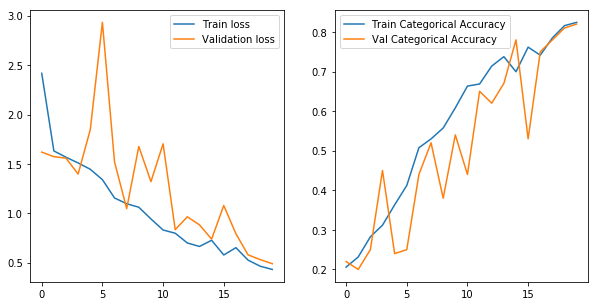

In [60]:
conv3d_9.plot_model_perf(model_11)

In [64]:
# Decreasing the Frame per i/p
conv3d_10 = Model_CNN9()
conv3d_10.set_dataset_directory()
conv3d_10.setting_conf(100,100, total_frame_per_video = 15, 
                           frame_ip = 10, batch_size = 50, num_of_epochs = 15)
conv3d_10_model = conv3d_10.model_define()
conv3d_10_model.summary()

model_12 = conv3d_10.model_train(conv3d_10_model, need_augmentation=True)

Setting the Dataset Specific Parameter
# training sequences = 663
# validation sequences = 100
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_69 (Conv3D)           (None, 10, 100, 100, 16)  400       
_________________________________________________________________
batch_normalization_69 (Batc (None, 10, 100, 100, 16)  64        
_________________________________________________________________
activation_69 (Activation)   (None, 10, 100, 100, 16)  0         
_________________________________________________________________
max_pooling3d_69 (MaxPooling (None, 5, 50, 50, 16)     0         
_________________________________________________________________
conv3d_70 (Conv3D)           (None, 5, 50, 50, 32)     4128      
_________________________________________________________________
batch_normalization_70 (Batc (None, 5, 50, 50, 32)     128       
_______________________________________________

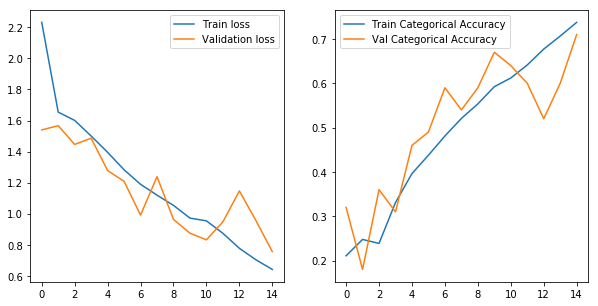

In [65]:
conv3d_10.plot_model_perf(model_12)

### Model 10  (CNN 3D)

In [3]:
class Model_CNN10(modelSkeleton):
    def model_define(self):
        """
        Changed feature maps of Conv layers, decreased neurons, 
        Added Batch Normalization in the dense layer and reduced training parameters.
        """
        model = Sequential()
        
        model.add(Conv3D(8, kernel_size=(3, 3, 3), padding='same', 
                 input_shape=(self.frame_ip,self.height,self.width,self.channel)))
        model.add(BatchNormalization())
        model.add(Activation(activations.relu))
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        
        model.add(Conv3D(16, kernel_size=(2, 2, 2), padding='same'))
        model.add(BatchNormalization())
        model.add(Activation(activations.relu))
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        
        model.add(Conv3D(32, kernel_size=(2, 2, 2), padding='same'))
        model.add(BatchNormalization())
        model.add(Activation(activations.relu))
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        
        model.add(Conv3D(64, kernel_size=(2, 2, 2), padding='same'))
        model.add(BatchNormalization())
        model.add(Activation(activations.relu))
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
                
        model.add(Flatten())
        model.add(Dense(64,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(0.25)) 
        model.add(Dense(32,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(0.25)) 
        model.add(Dense(self.no_of_class,activation='softmax'))
        
        model.compile(optimizer=optimizers.Adam(), loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [4]:
# Increasing the batch size
conv3d_11 = Model_CNN10()
conv3d_11.set_dataset_directory()
conv3d_11.setting_conf(100,100, total_frame_per_video = 30, 
                           frame_ip = 20, batch_size = 30, num_of_epochs = 20)
conv3d_11_model = conv3d_11.model_define()
conv3d_11_model.summary()

model_13 = conv3d_11.model_train(conv3d_11_model)

Setting the Dataset Specific Parameter
# training sequences = 663
# validation sequences = 100
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_1 (Conv3D)            (None, 20, 100, 100, 8)   656       
_________________________________________________________________
batch_normalization_1 (Batch (None, 20, 100, 100, 8)   32        
_________________________________________________________________
activation_1 (Activation)    (None, 20, 100, 100, 8)   0         
_________________________________________________________________
max_pooling3d_1 (MaxPooling3 (None, 10, 50, 50, 8)     0         
_________________________________________________________________
conv3d_2 (Conv3D)            (None, 10, 50, 50, 16)    1040      
_________________________________________________________________
batch_normalization_2 (Batch (None, 10, 50, 50, 16)    64        
_______________________________________________

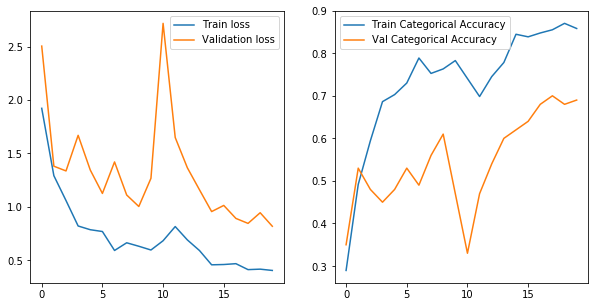

In [5]:
conv3d_11.plot_model_perf(model_13)

### Model 11  (CNN 3D)

In [6]:
class Model_CNN11(modelSkeleton):
    def model_define(self):
        """
        Removed Dropout from the dense layers except the last layer.
        """
        model = Sequential()
        
        model.add(Conv3D(8, kernel_size=(3, 3, 3), padding='same', 
                 input_shape=(self.frame_ip,self.height,self.width,self.channel)))
        model.add(BatchNormalization())
        model.add(Activation(activations.relu))
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        
        model.add(Conv3D(16, kernel_size=(3, 3, 3), padding='same'))
        model.add(BatchNormalization())
        model.add(Activation(activations.relu))
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        
        model.add(Conv3D(32, kernel_size=(2, 2, 2), padding='same'))
        model.add(BatchNormalization())
        model.add(Activation(activations.relu))
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        
        model.add(Conv3D(64, kernel_size=(2, 2, 2), padding='same'))
        model.add(BatchNormalization())
        model.add(Activation(activations.relu))
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
                
        model.add(Flatten())
        model.add(Dense(64,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dense(64,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(0.25)) 
        model.add(Dense(self.no_of_class,activation='softmax'))
        
        model.compile(optimizer=optimizers.Adam(), loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [7]:
conv3d_12 = Model_CNN11()
conv3d_12.set_dataset_directory()
conv3d_12.setting_conf(100,100, total_frame_per_video = 30, 
                           frame_ip = 20, batch_size = 30, num_of_epochs = 20)
conv3d_12_model = conv3d_12.model_define()
conv3d_12_model.summary()

model_14 = conv3d_12.model_train(conv3d_12_model)

Setting the Dataset Specific Parameter
# training sequences = 663
# validation sequences = 100
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_5 (Conv3D)            (None, 20, 100, 100, 8)   656       
_________________________________________________________________
batch_normalization_7 (Batch (None, 20, 100, 100, 8)   32        
_________________________________________________________________
activation_5 (Activation)    (None, 20, 100, 100, 8)   0         
_________________________________________________________________
max_pooling3d_5 (MaxPooling3 (None, 10, 50, 50, 8)     0         
_________________________________________________________________
conv3d_6 (Conv3D)            (None, 10, 50, 50, 16)    3472      
_________________________________________________________________
batch_normalization_8 (Batch (None, 10, 50, 50, 16)    64        
_______________________________________________

23/23 [==============================] - 72s 3s/step - loss: 0.2629 - categorical_accuracy: 0.9231 - val_loss: 0.7860 - val_categorical_accuracy: 0.6800

Epoch 00017: saving model to training_models/model_init_2020-05-2310_32_59.197001/model-00017-0.27243-0.92006-0.78595-0.68000.h5
Epoch 18/20
23/23 [==============================] - 69s 3s/step - loss: 0.2573 - categorical_accuracy: 0.9332 - val_loss: 0.8419 - val_categorical_accuracy: 0.6300

Epoch 00018: saving model to training_models/model_init_2020-05-2310_32_59.197001/model-00018-0.26009-0.93062-0.84191-0.63000.h5
Epoch 19/20
23/23 [==============================] - 69s 3s/step - loss: 0.2315 - categorical_accuracy: 0.9448 - val_loss: 0.7859 - val_categorical_accuracy: 0.6600

Epoch 00019: saving model to training_models/model_init_2020-05-2310_32_59.197001/model-00019-0.23053-0.94268-0.78590-0.66000.h5
Epoch 20/20
23/23 [==============================] - 70s 3s/step - loss: 0.2303 - categorical_accuracy: 0.9492 - val_loss: 0.83

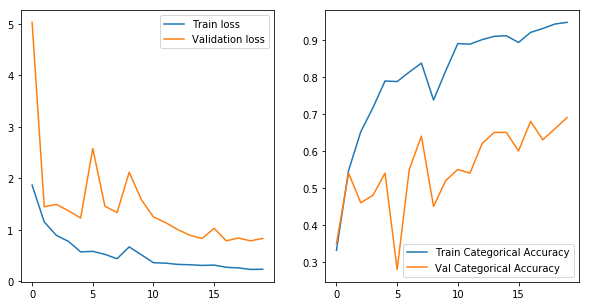

In [8]:
conv3d_12.plot_model_perf(model_14)

In [3]:
# Creating an Abstract class this will hold hold the primary skeleton code that will 
# be inherited and implemented by different model class
class modelSkeletonLessAugmentation(ABC):
    
    def set_dataset_directory(self):
        """
        This will set the Dataset Spefic Details
        """
        print("Setting the Dataset Specific Parameter")
        self.train_doc = np.random.permutation(open('train.csv').readlines())
        self.val_doc = np.random.permutation(open('val.csv').readlines())
        self.train_path = 'train'
        self.val_path = 'val'
        self.num_train_sequences = len(self.train_doc)
        print('# training sequences =', self.num_train_sequences)
        self.num_val_sequences = len(self.val_doc)
        print('# validation sequences =', self.num_val_sequences)
        
    
    def generator(self, source_path, folder_list, need_augmentation = False):
        """
        This method will generate the set of images that will be fed onto the Model
        """
        batch_size=self.batch_size
        print( 'Source path = ', source_path, '; batch size =', batch_size)
        #create a list of image numbers you want to use for a particular video
        img_idx = sorted(np.random.choice(range(self.total_frame_per_video), self.frame_ip, replace=False))

        while True:
            t = np.random.permutation(folder_list)
            num_batches = len(folder_list)//batch_size # calculate the number of batches
            for batch in range(num_batches): # we iterate over the number of batches
                yield self.processed_batch_data(img_idx, source_path, batch_size, batch, t, need_augmentation)
            
            #remaining data points which are left after full batches
            remaining_data_point_len = len(folder_list) % batch_size
            if remaining_data_point_len > 0:
                yield self.processed_batch_data(img_idx, source_path, batch_size, batch, t, need_augmentation, remaining_data_point_len)
                
    def normalized_image(self,img):
        """
        Normalizing the Image Pixel and Using the Percentile Approach so as to deal with Outliers
        """
        return (img - np.percentile(img,5))/(np.percentile(img,95) - np.percentile(img,5))
    
    def perf_rotation(self, image):
        """
        Here the Images will be rotated by 20 degree and it will be resized and normalized
        """
        # specify x and y coordinates to be used for shifting (mid points)
        shift_x, shift_y = image.shape[0]/2, image.shape[1]/2
        # translation by certain units
        matrix_to_topleft = trans.SimilarityTransform(translation=[-shift_x, -shift_y])
        matrix_to_center = trans.SimilarityTransform(translation=[shift_x, shift_y])

        # rotation ( Rotation by 20 degrees)
        rot_transforms =  trans.AffineTransform(rotation=np.deg2rad(20))
        rot_matrix = matrix_to_topleft + rot_transforms + matrix_to_center
        rot_image = trans.warp(image, rot_matrix)
        
        # Resizing of the image
        resized_image = imresize(rot_image,(self.height,self.width,self.channel))
        
        # Perform Normalization 
        return self.normalized_image(resized_image[:,:,0]),self.normalized_image(resized_image[:,:,1]), self.normalized_image(resized_image[:,:,2]) 
    
    def per_scaling(self, image):
        """
        Perform Scaling to the image 
        """
        # specify x and y coordinates to be used for shifting (mid points)
        shift_x, shift_y = image.shape[0]/2, image.shape[1]/2
        
        # translation by certain units
        matrix_to_topleft = trans.SimilarityTransform(translation=[-shift_x, -shift_y])
        matrix_to_center = trans.SimilarityTransform(translation=[shift_x, shift_y])
        
        scale_transforms = trans.AffineTransform(scale=(0.8, 0.8))
        scale_matrix = matrix_to_topleft + scale_transforms + matrix_to_center
        scale_image_zoom_out = trans.warp(image, scale_matrix)
        
        # Resizing of the image
        resized_image = imresize(scale_image_zoom_out,(self.height,self.width,self.channel))
        
        # Perform Normalization 
        return self.normalized_image(resized_image[:,:,0]),self.normalized_image(resized_image[:,:,1]), self.normalized_image(resized_image[:,:,2])         
    
    def morphological_transformation(self, image):
        """
        Then so as to identify the edge morphological transformation is performed
        Erosion is done, so as to shrink bright regions and enlarges dark regions
        Openning is erosion followed by dilation. Opening can remove small bright spots (i.e. “salt”) 
        and connect small dark cracks
        """
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        blur = cv2.GaussianBlur(image,(1,1),0.5).astype('uint8')   
        th3 = cv2.adaptiveThreshold(blur,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,cv2.THRESH_BINARY_INV,11,2)
        mask1 = cv2.erode(th3, cv2.getStructuringElement(cv2.MORPH_RECT,(1,1)), iterations = 3)
        mask1 = cv2.morphologyEx(mask1, cv2.MORPH_OPEN, cv2.getStructuringElement(cv2.MORPH_RECT,(2,2)))
        # Changing from 1 color channel to 3 color channel
        mask1 = cv2.cvtColor(mask1, cv2.COLOR_GRAY2BGR)
        # Resizing of the image
        resized_image = imresize(mask1,(self.height,self.width,self.channel))
        
        # Perform Normalization 
        return self.normalized_image(resized_image[:,:,0]),self.normalized_image(resized_image[:,:,1]), self.normalized_image(resized_image[:,:,2])
    
    def processed_batch_data(self,img_idx,source_path,batch_size, batch, t, need_augmentation, remaining_data_point_len = 0 ):
        """
        This method will get the images per batch and also do the Image Preprocessing
        1. Resizing 
        2. Normalization
        3. Morphological Transformation
        4. Data Augmentation
        5. One ot vector of the batch labels
        """
        
        # Remaining data points which are left after full batches
        # If the Number of Data point is Perfectly Divisble by Batch Size then there won't be any remaining data point
        # If not then there will be some remaining data point in the last batch, so as to make a sequence using those
        # Remaining Data point
        
        if remaining_data_point_len > 0:
            no_data_in_seq = remaining_data_point_len
        else:
            no_data_in_seq = batch_size
            
        batch_data = np.zeros((no_data_in_seq, len(img_idx), self.height, self.width, self.channel))
        batch_labels = np.zeros((no_data_in_seq,self.no_of_class))
        
        # If the data augmentation is required
        if need_augmentation :
#             batch_scaled_data = np.zeros((no_data_in_seq, len(img_idx), self.height, self.width, self.channel))
#             batch_rotated_data = np.zeros((no_data_in_seq, len(img_idx), self.height, self.width, self.channel))
            batch_morp_data = np.zeros((no_data_in_seq, len(img_idx), self.height, self.width, self.channel))
        
        # iterate over number of Folders
        for folder in range(no_data_in_seq):
            imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0])
            for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                #crop the images and resize them. Note that the images are of 2 different shape 
                #and the conv3D will throw error if the inputs in a batch have different shapes
                resized_image = imresize(image,(self.height,self.width,self.channel))
                
                batch_data[folder,idx,:,:,0] = self.normalized_image(resized_image[:,:,0]) #normalise and feed in the image
                batch_data[folder,idx,:,:,1] = self.normalized_image(resized_image[:,:,1]) #normalise and feed in the image
                batch_data[folder,idx,:,:,2] = self.normalized_image(resized_image[:,:,2]) #normalise and feed in the image
                
                if need_augmentation :
#                     batch_rotated_data[folder,idx,:,:,0],batch_rotated_data[folder,idx,:,:,1],batch_rotated_data[folder,idx,:,:,2] = self.perf_rotation(image)
#                     batch_scaled_data[folder,idx,:,:,0],batch_scaled_data[folder,idx,:,:,1],batch_scaled_data[folder,idx,:,:,2] = self.per_scaling(image)
                    batch_morp_data[folder,idx,:,:,0],batch_morp_data[folder,idx,:,:,1],batch_morp_data[folder,idx,:,:,2] = self.morphological_transformation(image)
            
            # Creating the one hot vector for the Labels
            batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
        
        if need_augmentation :
#             batch_data=  np.concatenate([batch_data,batch_scaled_data, batch_rotated_data, batch_morp_data])
#             batch_labels=np.concatenate([batch_labels,batch_labels, batch_labels, batch_labels])
            batch_data=  np.concatenate([batch_data, batch_morp_data])
            batch_labels=np.concatenate([batch_labels, batch_labels])
            
        return(batch_data, batch_labels)
            
    def setting_conf(self, height, width, channel = 3, no_of_class = 5, total_frame_per_video = 15, 
                           frame_ip = 15, batch_size = 50, num_of_epochs = 2):
        """
        Setting The Image Specific Property
        Setting the model Specific Hyperparameter
        These are main set of parameters whose final value will be decided based on Trial and Error
        """
        self.height = height
        self.width = width
        self.channel = channel
        self.no_of_class = no_of_class
        self.total_frame_per_video = total_frame_per_video
        self.frame_ip = frame_ip
        self.batch_size = batch_size
        self.num_of_epochs = num_of_epochs
    
    def model_train(self, model, need_augmentation=False):
        """
         1. Generate the batch data for Train and Validation
         2. Generate the Model Path where the model will be stored
         3. Control the LR when the Validation loss hits plateau
         4. Determine the Number of data per epochs and in validation
        """
        #Let us create the train_generator and the val_generator which will be used in .fit_generator.
        train_generator = self.generator(self.train_path, self.train_doc, need_augmentation)
        val_generator = self.generator(self.val_path, self.val_doc)
        model_path = 'training_models'
        if not os.path.exists(model_path):
            os.mkdir(model_path)
        model_name = model_path + '/' + 'model_init' + '_' + str(datetime.datetime.now()).replace(' ','').replace(':','_') + '/'
        if not os.path.exists(model_name):
            os.mkdir(model_name)
        filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'
        checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)
        
        # Reduce learning rate when a metric has stopped improving.
        LR = ReduceLROnPlateau(monitor="val_loss", factor = 0.1, patience = 5 , min_lr=0.0001 )
        callbacks_list = [checkpoint, LR]
        
        if (self.num_train_sequences%self.batch_size) == 0:
            steps_per_epoch = int(self.num_train_sequences/self.batch_size)
        else:
            steps_per_epoch = (self.num_train_sequences//self.batch_size) + 1

        if (self.num_val_sequences%self.batch_size) == 0:
            validation_steps = int(self.num_val_sequences/self.batch_size)
        else:
            validation_steps = (self.num_val_sequences//self.batch_size) + 1        
        
        print(f'steps_per_epoch: {steps_per_epoch}')
        print(f'validation_steps: {validation_steps}')

        
        model_history = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=self.num_of_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)
        return model_history
    
    def plot_model_perf(self,model_history):
        """
         This will plot models performance ( loss and the accuracy)
        """
        fig, ax = plt.subplots(1, 2, figsize=(10,5))
        ax[0].plot(model_history.history['loss'])   
        ax[0].plot(model_history.history['val_loss'])
        ax[0].legend(['Train loss','Validation loss'])
        
        # https://keras.io/api/metrics/accuracy_metrics/#categoricalaccuracy-class
        ax[1].plot(model_history.history['categorical_accuracy'])   
        ax[1].plot(model_history.history['val_categorical_accuracy'])
        ax[1].legend(['Train Categorical Accuracy','Val Categorical Accuracy'])
        
    # In this method the actual code of different model will be available
    @abstractmethod
    def model_define(self):
        pass

### Model 12 - CNN 3D with less augmentation

In [15]:
class Model_CNN9withLessAugmentation(modelSkeletonLessAugmentation):
    def model_define(self):
        """
        The model is similar to model 3 except the first Conv layer. No regularization 
        parameters have been used except on last dense layer and learning rate on optimizer was specified as 0.0001.
        """
        model = Sequential()
        model.add(Conv3D(16, kernel_size=(2, 2, 2), padding='same', 
                 input_shape=(self.frame_ip,self.height,self.width,self.channel)))
        model.add(BatchNormalization())
        model.add(Activation(activations.relu))
        model.add(MaxPooling3D(pool_size=(2, 2, 2), padding='same'))
        
        model.add(Conv3D(32, kernel_size=(2, 2, 2), padding='same'))
        model.add(BatchNormalization())
        model.add(Activation(activations.relu))
        model.add(MaxPooling3D(pool_size=(2, 2, 2), padding='same'))
        
        model.add(Conv3D(64, kernel_size=(2, 2, 2), padding='same'))
        model.add(BatchNormalization())
        model.add(Activation(activations.relu))
        model.add(MaxPooling3D(pool_size=(2, 2, 2), padding='same'))
        
        model.add(Conv3D(128, kernel_size=(2, 2, 2), padding='same'))
        model.add(BatchNormalization())
        model.add(Activation(activations.relu))
        model.add(MaxPooling3D(pool_size=(2, 2, 2), padding='same'))
        
                
        model.add(Flatten())
        model.add(Dense(128,activation='relu'))
        model.add(Dense(64,activation='relu'))
        model.add(Dropout(0.25))
        model.add(Dense(self.no_of_class,activation='softmax'))
        
        model.compile(optimizer=optimizers.Adam(lr = 0.0001), loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [16]:
# Decreasing the Frame per i/p
conv3d_13 = Model_CNN9withLessAugmentation()
conv3d_13.set_dataset_directory()
conv3d_13.setting_conf(100,100, total_frame_per_video = 30, 
                           frame_ip = 15, batch_size = 30, num_of_epochs = 20)
conv3d_13_model = conv3d_13.model_define()
conv3d_13_model.summary()

model_15 = conv3d_13.model_train(conv3d_13_model, need_augmentation=True)

Setting the Dataset Specific Parameter
# training sequences = 663
# validation sequences = 100
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_17 (Conv3D)           (None, 15, 100, 100, 16)  400       
_________________________________________________________________
batch_normalization_21 (Batc (None, 15, 100, 100, 16)  64        
_________________________________________________________________
activation_17 (Activation)   (None, 15, 100, 100, 16)  0         
_________________________________________________________________
max_pooling3d_17 (MaxPooling (None, 8, 50, 50, 16)     0         
_________________________________________________________________
conv3d_18 (Conv3D)           (None, 8, 50, 50, 32)     4128      
_________________________________________________________________
batch_normalization_22 (Batc (None, 8, 50, 50, 32)     128       
_______________________________________________


Epoch 00017: saving model to training_models/model_init_2020-05-2311_09_57.453270/model-00017-0.61414-0.77451-1.02321-0.60000.h5
Epoch 18/20
23/23 [==============================] - 92s 4s/step - loss: 0.5641 - categorical_accuracy: 0.8203 - val_loss: 1.0132 - val_categorical_accuracy: 0.5800

Epoch 00018: saving model to training_models/model_init_2020-05-2311_09_57.453270/model-00018-0.55687-0.81976-1.01318-0.58000.h5
Epoch 19/20
23/23 [==============================] - 91s 4s/step - loss: 0.5238 - categorical_accuracy: 0.8153 - val_loss: 0.9183 - val_categorical_accuracy: 0.5900

Epoch 00019: saving model to training_models/model_init_2020-05-2311_09_57.453270/model-00019-0.50773-0.83409-0.91827-0.59000.h5
Epoch 20/20
23/23 [==============================] - 92s 4s/step - loss: 0.4719 - categorical_accuracy: 0.8468 - val_loss: 0.9634 - val_categorical_accuracy: 0.6000

Epoch 00020: saving model to training_models/model_init_2020-05-2311_09_57.453270/model-00020-0.48303-0.84087-0.96

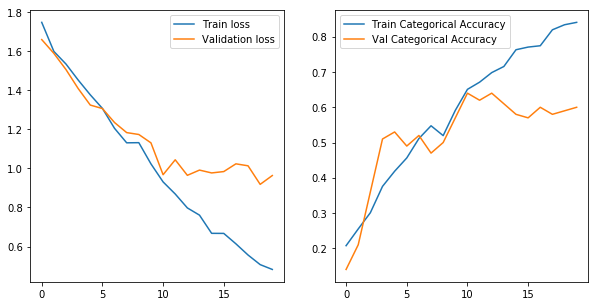

In [17]:
conv3d_13.plot_model_perf(model_15)

### Model 1  (CNN 2D + GRU)

In [5]:
class Model_CNN12d(modelSkeleton):
    def model_define(self):
        """
        Added 3 layers of Conv2D to keep the model simple with one GRU with 
        smaller number of neurons and Dropout at the last Dense layer.
        """
        model = Sequential()
        model.add(TimeDistributed(Conv2D(16, (2, 2) , padding='same'),
                                  input_shape=(self.frame_ip,self.height,self.width,self.channel)))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(Activation(activations.relu)))
        model.add(TimeDistributed(MaxPooling2D(pool_size=(2, 2), padding='same')))
        
        model.add(TimeDistributed(Conv2D(32, (2, 2) , padding='same')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(Activation(activations.relu)))
        model.add(TimeDistributed(MaxPooling2D(pool_size=(2, 2), padding='same')))

        model.add(TimeDistributed(Conv2D(64, (2, 2) , padding='same')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(Activation(activations.relu)))
        model.add(TimeDistributed(MaxPooling2D(pool_size=(2, 2), padding='same')))
        
        model.add(TimeDistributed(Flatten()))
        model.add(GRU(64))
        model.add(Dense(32,activation='relu'))
        model.add(Dropout(0.25))
        model.add(Dense(self.no_of_class,activation='softmax'))
        
        model.compile(optimizer=optimizers.Adam(), loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [10]:
# Decreasing the Frame per i/p
conv2d_lstm1 = Model_CNN12d()
conv2d_lstm1.set_dataset_directory()
conv2d_lstm1.setting_conf(100,100, total_frame_per_video = 30, 
                           frame_ip = 15, batch_size = 30, num_of_epochs = 10)
conv2d_lstm1_model = conv2d_lstm1.model_define()
conv2d_lstm1_model.summary()

model_16 = conv2d_lstm1.model_train(conv2d_lstm1_model)

Setting the Dataset Specific Parameter
# training sequences = 663
# validation sequences = 100
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_4 (TimeDist (None, 15, 100, 100, 16)  208       
_________________________________________________________________
time_distributed_5 (TimeDist (None, 15, 100, 100, 16)  64        
_________________________________________________________________
time_distributed_6 (TimeDist (None, 15, 100, 100, 16)  0         
_________________________________________________________________
time_distributed_7 (TimeDist (None, 15, 50, 50, 16)    0         
_________________________________________________________________
time_distributed_8 (TimeDist (None, 15, 50, 50, 32)    2080      
_________________________________________________________________
time_distributed_9 (TimeDist (None, 15, 50, 50, 32)    128       
_______________________________________________

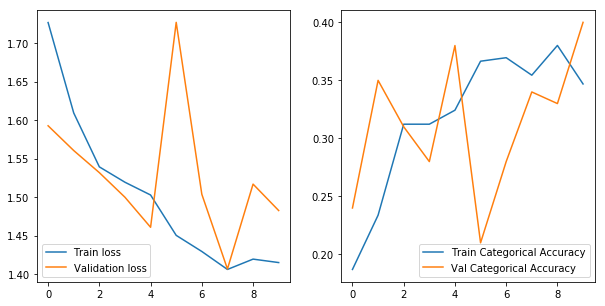

In [12]:
conv2d_lstm1.plot_model_perf(model_16)

### Model 2  (CNN 2D + GRU)

In [13]:
class Model_CNN22d(modelSkeleton):
    def model_define(self):
        """
        Added one more layer of Conv2D and removed dropout from the dense layer.
        """
        model = Sequential()
        model.add(TimeDistributed(Conv2D(16, (3, 3) , padding='same'),
                                  input_shape=(self.frame_ip,self.height,self.width,self.channel)))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(Activation(activations.relu)))
        model.add(TimeDistributed(MaxPooling2D(pool_size=(2, 2), padding='same')))
        
        model.add(TimeDistributed(Conv2D(32, (3, 3) , padding='same')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(Activation(activations.relu)))
        model.add(TimeDistributed(MaxPooling2D(pool_size=(2, 2), padding='same')))

        model.add(TimeDistributed(Conv2D(64, (2, 2) , padding='same')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(Activation(activations.relu)))
        model.add(TimeDistributed(MaxPooling2D(pool_size=(2, 2), padding='same')))
        
        model.add(TimeDistributed(Conv2D(128, (2, 2) , padding='same')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(Activation(activations.relu)))
        model.add(TimeDistributed(MaxPooling2D(pool_size=(2, 2), padding='same')))
        
        model.add(TimeDistributed(Flatten()))
        model.add(GRU(64))
        model.add(Dense(32,activation='relu'))
        model.add(Dense(self.no_of_class,activation='softmax'))
        
        model.compile(optimizer=optimizers.Adam(), loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [14]:
# Decreasing the Frame per i/p
conv2d_lstm2 = Model_CNN22d()
conv2d_lstm2.set_dataset_directory()
conv2d_lstm2.setting_conf(100,100, total_frame_per_video = 30, 
                           frame_ip = 15, batch_size = 30, num_of_epochs = 10)
conv2d_lstm2_model = conv2d_lstm2.model_define()
conv2d_lstm2_model.summary()

model_17 = conv2d_lstm2.model_train(conv2d_lstm2_model)

Setting the Dataset Specific Parameter
# training sequences = 663
# validation sequences = 100
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_17 (TimeDis (None, 15, 100, 100, 16)  448       
_________________________________________________________________
time_distributed_18 (TimeDis (None, 15, 100, 100, 16)  64        
_________________________________________________________________
time_distributed_19 (TimeDis (None, 15, 100, 100, 16)  0         
_________________________________________________________________
time_distributed_20 (TimeDis (None, 15, 50, 50, 16)    0         
_________________________________________________________________
time_distributed_21 (TimeDis (None, 15, 50, 50, 32)    4640      
_________________________________________________________________
time_distributed_22 (TimeDis (None, 15, 50, 50, 32)    128       
_______________________________________________

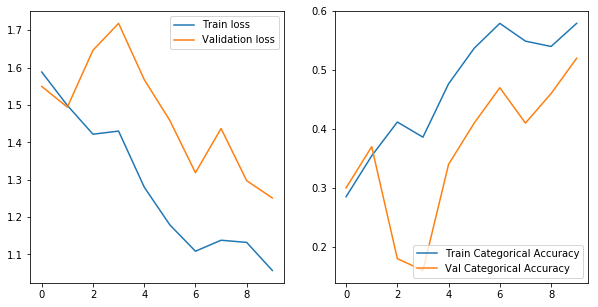

In [15]:
conv2d_lstm2.plot_model_perf(model_17)

In [16]:
conv2d_lstm3 = Model_CNN22d()
conv2d_lstm3.set_dataset_directory()
conv2d_lstm3.setting_conf(100,100, total_frame_per_video = 30, 
                           frame_ip = 20, batch_size = 20, num_of_epochs = 15)
conv2d_lstm3_model = conv2d_lstm3.model_define()
conv2d_lstm3_model.summary()

model_18 = conv2d_lstm3.model_train(conv2d_lstm3_model)

Setting the Dataset Specific Parameter
# training sequences = 663
# validation sequences = 100
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_34 (TimeDis (None, 20, 100, 100, 16)  448       
_________________________________________________________________
time_distributed_35 (TimeDis (None, 20, 100, 100, 16)  64        
_________________________________________________________________
time_distributed_36 (TimeDis (None, 20, 100, 100, 16)  0         
_________________________________________________________________
time_distributed_37 (TimeDis (None, 20, 50, 50, 16)    0         
_________________________________________________________________
time_distributed_38 (TimeDis (None, 20, 50, 50, 32)    4640      
_________________________________________________________________
time_distributed_39 (TimeDis (None, 20, 50, 50, 32)    128       
_______________________________________________

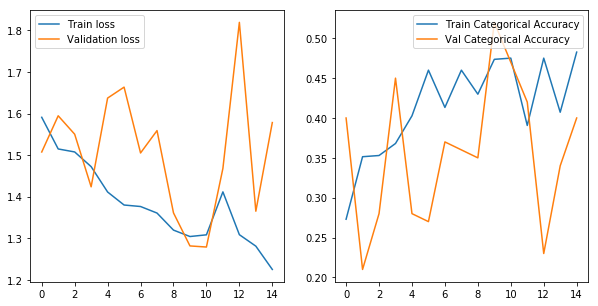

In [17]:
conv2d_lstm3.plot_model_perf(model_18)

### Model 3  (CNN 2D + GRU)

In [18]:
class Model_CNN32d(modelSkeleton):
    def model_define(self):
        """
        Increased kernel size of every Conv2D layers and added Batch Normalization 
        in the dense layer. Changed the padding type in pooling layers.
        """
        model = Sequential()
        model.add(TimeDistributed(Conv2D(16, (3, 3) , padding='same'),
                                  input_shape=(self.frame_ip,self.height,self.width,self.channel)))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(Activation(activations.relu)))
        model.add(TimeDistributed(MaxPooling2D(pool_size=(2, 2))))
        
        model.add(TimeDistributed(Conv2D(32, (3, 3) , padding='same')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(Activation(activations.relu)))
        model.add(TimeDistributed(MaxPooling2D(pool_size=(2, 2))))

        model.add(TimeDistributed(Conv2D(64, (3, 3) , padding='same')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(Activation(activations.relu)))
        model.add(TimeDistributed(MaxPooling2D(pool_size=(2, 2))))
        
        model.add(TimeDistributed(Conv2D(128, (3, 3) , padding='same')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(Activation(activations.relu)))
        model.add(TimeDistributed(MaxPooling2D(pool_size=(2, 2))))
        
        model.add(TimeDistributed(Flatten()))
        model.add(GRU(64))
        model.add(Dense(64,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dense(32,activation='relu'))
        model.add(Dense(self.no_of_class,activation='softmax'))
        
        model.compile(optimizer=optimizers.Adam(), loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [19]:
# Decreasing the Frame per i/p
conv2d_lstm4 = Model_CNN32d()
conv2d_lstm4.set_dataset_directory()
conv2d_lstm4.setting_conf(100,100, total_frame_per_video = 30, 
                           frame_ip = 15, batch_size = 30, num_of_epochs = 10)
conv2d_lstm4_model = conv2d_lstm4.model_define()
conv2d_lstm4_model.summary()

model_19 = conv2d_lstm4.model_train(conv2d_lstm4_model)

Setting the Dataset Specific Parameter
# training sequences = 663
# validation sequences = 100
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_51 (TimeDis (None, 15, 100, 100, 16)  448       
_________________________________________________________________
time_distributed_52 (TimeDis (None, 15, 100, 100, 16)  64        
_________________________________________________________________
time_distributed_53 (TimeDis (None, 15, 100, 100, 16)  0         
_________________________________________________________________
time_distributed_54 (TimeDis (None, 15, 50, 50, 16)    0         
_________________________________________________________________
time_distributed_55 (TimeDis (None, 15, 50, 50, 32)    4640      
_________________________________________________________________
time_distributed_56 (TimeDis (None, 15, 50, 50, 32)    128       
_______________________________________________

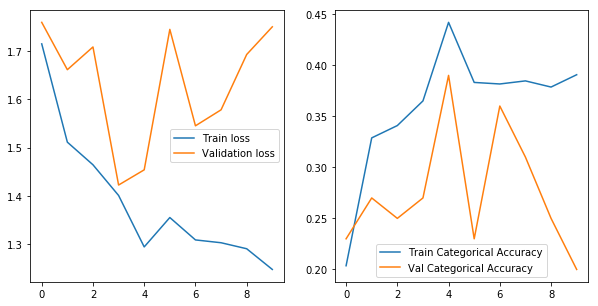

In [20]:
conv2d_lstm4.plot_model_perf(model_19)

### Model 4  (CNN 2D + GRU)

In [21]:
class Model_CNN42d(modelSkeleton):
    def model_define(self):
        """
        Made the model simpler by removing last Conv2D layer. 
        Also, learning rate was specified in the model as 0.01.
        """
        model = Sequential()
        model.add(TimeDistributed(Conv2D(8, (3, 3) , padding='same'),
                                  input_shape=(self.frame_ip,self.height,self.width,self.channel)))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(Activation(activations.relu)))
        model.add(TimeDistributed(MaxPooling2D(pool_size=(2, 2))))
        
        model.add(TimeDistributed(Conv2D(16, (3, 3) , padding='same')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(Activation(activations.relu)))
        model.add(TimeDistributed(MaxPooling2D(pool_size=(2, 2))))

        model.add(TimeDistributed(Conv2D(32, (2, 2) , padding='same')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(Activation(activations.relu)))
        model.add(TimeDistributed(MaxPooling2D(pool_size=(2, 2))))
        
        model.add(TimeDistributed(Flatten()))
        model.add(GRU(64))
        model.add(Dense(64,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dense(32,activation='relu'))
        model.add(Dense(self.no_of_class,activation='softmax'))
        
        model.compile(optimizer=optimizers.Adam(lr = 0.01), loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [22]:
# Decreasing the Frame per i/p
conv2d_lstm5 = Model_CNN42d()
conv2d_lstm5.set_dataset_directory()
conv2d_lstm5.setting_conf(100,100, total_frame_per_video = 30, 
                           frame_ip = 20, batch_size = 20, num_of_epochs = 10)
conv2d_lstm5_model = conv2d_lstm5.model_define()
conv2d_lstm5_model.summary()

model_20 = conv2d_lstm5.model_train(conv2d_lstm5_model)

Setting the Dataset Specific Parameter
# training sequences = 663
# validation sequences = 100
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_68 (TimeDis (None, 20, 100, 100, 8)   224       
_________________________________________________________________
time_distributed_69 (TimeDis (None, 20, 100, 100, 8)   32        
_________________________________________________________________
time_distributed_70 (TimeDis (None, 20, 100, 100, 8)   0         
_________________________________________________________________
time_distributed_71 (TimeDis (None, 20, 50, 50, 8)     0         
_________________________________________________________________
time_distributed_72 (TimeDis (None, 20, 50, 50, 16)    1168      
_________________________________________________________________
time_distributed_73 (TimeDis (None, 20, 50, 50, 16)    64        
_______________________________________________

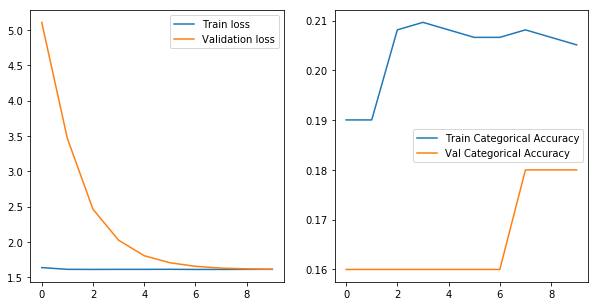

In [23]:
conv2d_lstm5.plot_model_perf(model_20)

### Model 5  (CNN 2D + GRU)

In [35]:
class Model_CNN52d(modelSkeleton):
    def model_define(self):
        """
        Added 2 layers at the start and 1 layer at the end to make 
        the model a bit complex as in model 13 there was an improvement
        """
        model = Sequential()
        model.add(TimeDistributed(Conv2D(16, (3, 3) , padding='same'),
                                  input_shape=(self.frame_ip,self.height,self.width,self.channel)))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(Activation(activations.relu)))
        model.add(TimeDistributed(MaxPooling2D(pool_size=(2,2), padding='SAME',strides=(2,2))))
        
        model.add(TimeDistributed(Conv2D(16, (3, 3) , padding='same')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(Activation(activations.relu)))
        model.add(TimeDistributed(MaxPooling2D(pool_size=(2,2), padding='SAME',strides=(2,2))))
        
        model.add(TimeDistributed(Conv2D(32, (3, 3) , padding='same')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(Activation(activations.relu)))
        model.add(TimeDistributed(MaxPooling2D(pool_size=(2,2), padding='SAME',strides=(2,2))))

        model.add(TimeDistributed(Conv2D(64, (3, 3) , padding='same')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(Activation(activations.relu)))
        model.add(TimeDistributed(MaxPooling2D(pool_size=(2,2), padding='SAME',strides=(2,2))))
        
        model.add(TimeDistributed(Conv2D(128, (3, 3) , padding='same')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(Activation(activations.relu)))
        model.add(TimeDistributed(MaxPooling2D(pool_size=(2,2), padding='SAME',strides=(2,2))))
        
        model.add(TimeDistributed(Flatten()))
        model.add(GRU(64))
        model.add(Dense(64,activation='relu'))
        model.add(Dense(32,activation='relu'))
        model.add(Dense(self.no_of_class,activation='softmax'))
        
        model.compile(optimizer=optimizers.Adam(), loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [36]:
# Decreasing the Frame per i/p
conv2d_lstm6 = Model_CNN52d()
conv2d_lstm6.set_dataset_directory()
conv2d_lstm6.setting_conf(100,100, total_frame_per_video = 30, 
                           frame_ip = 20, batch_size = 20, num_of_epochs = 10)
conv2d_lstm6_model = conv2d_lstm6.model_define()
conv2d_lstm6_model.summary()

model_21 = conv2d_lstm6.model_train(conv2d_lstm6_model)

Setting the Dataset Specific Parameter
# training sequences = 663
# validation sequences = 100
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_149 (TimeDi (None, 20, 100, 100, 16)  448       
_________________________________________________________________
time_distributed_150 (TimeDi (None, 20, 100, 100, 16)  64        
_________________________________________________________________
time_distributed_151 (TimeDi (None, 20, 100, 100, 16)  0         
_________________________________________________________________
time_distributed_152 (TimeDi (None, 20, 50, 50, 16)    0         
_________________________________________________________________
time_distributed_153 (TimeDi (None, 20, 50, 50, 16)    2320      
_________________________________________________________________
time_distributed_154 (TimeDi (None, 20, 50, 50, 16)    64        
_______________________________________________

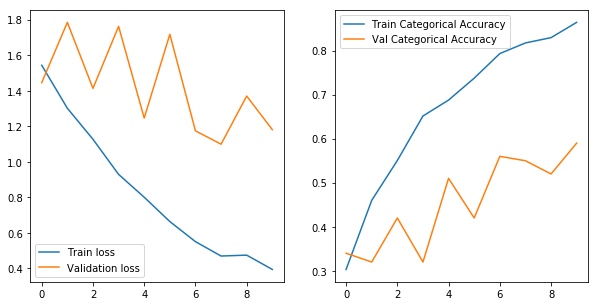

In [37]:
conv2d_lstm6.plot_model_perf(model_21)

### Model 6 (CNN 2D + GRU)

In [37]:
class Model_CNN62d(modelSkeleton):
    def model_define(self):
        """
        Removed the last layer and added GRU layer with a greater number of neurons
        after the Dense layer (This model of out of convention)
        """
        model = Sequential()
        model.add(TimeDistributed(Conv2D(8, (3, 3) , padding='same'),
                                  input_shape=(self.frame_ip,self.height,self.width,self.channel)))
        model.add(TimeDistributed(Activation(activations.relu)))
        model.add(TimeDistributed(MaxPooling2D(pool_size=(2,2), padding='SAME',strides=(2,2))))
        
        model.add(TimeDistributed(Conv2D(16, (3, 3) , padding='same')))
        model.add(TimeDistributed(Activation(activations.relu)))
        model.add(TimeDistributed(MaxPooling2D(pool_size=(2,2), padding='SAME',strides=(2,2))))
        
        model.add(TimeDistributed(Conv2D(32, (3, 3) , padding='same')))
        model.add(TimeDistributed(Activation(activations.relu)))
        model.add(TimeDistributed(MaxPooling2D(pool_size=(2,2), padding='SAME',strides=(2,2))))

        model.add(TimeDistributed(Conv2D(64, (3, 3) , padding='same')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(Activation(activations.relu)))
        model.add(TimeDistributed(MaxPooling2D(pool_size=(2,2), padding='SAME',strides=(2,2))))
        model.add(Dropout(0.25))
        
        model.add(TimeDistributed(Flatten()))
        
        model.add(Dense(128,activation='relu'))
        model.add(Dropout(0.25))
        model.add(Dense(64,activation='relu'))
        model.add(Dropout(0.25))
        model.add(GRU(128))
        model.add(Dense(self.no_of_class,activation='softmax'))
        
        model.compile(optimizer=optimizers.Adam(), loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [6]:
conv2d_lstm7 = Model_CNN62d()
conv2d_lstm7.set_dataset_directory()
conv2d_lstm7.setting_conf(100,100, total_frame_per_video = 30, 
                           frame_ip = 25, batch_size = 30, num_of_epochs = 20)
conv2d_lstm7_model = conv2d_lstm7.model_define()
conv2d_lstm7_model.summary()

model_22 = conv2d_lstm7.model_train(conv2d_lstm7_model)

Setting the Dataset Specific Parameter
# training sequences = 663
# validation sequences = 100
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_1 (TimeDist (None, 25, 100, 100, 8)   224       
_________________________________________________________________
time_distributed_2 (TimeDist (None, 25, 100, 100, 8)   0         
_________________________________________________________________
time_distributed_3 (TimeDist (None, 25, 50, 50, 8)     0         
_________________________________________________________________
time_distributed_4 (TimeDist (None, 25, 50, 50, 16)    1168      
_________________________________________________________________
time_distributed_5 (TimeDist (None, 25, 50, 50, 16)    0         
_________________________________________________________________
time_distributed_6 (TimeDist (None, 25, 25, 25, 16)    0         
_______________________________________________


Epoch 00017: saving model to training_models/model_init_2020-05-2320_59_48.945737/model-00017-0.05158-0.99095-1.16379-0.74000.h5
Epoch 18/20
23/23 [==============================] - 89s 4s/step - loss: 0.0436 - categorical_accuracy: 0.9956 - val_loss: 1.1801 - val_categorical_accuracy: 0.7300

Epoch 00018: saving model to training_models/model_init_2020-05-2320_59_48.945737/model-00018-0.04459-0.99548-1.18009-0.73000.h5
Epoch 19/20
23/23 [==============================] - 90s 4s/step - loss: 0.0385 - categorical_accuracy: 0.9956 - val_loss: 1.1745 - val_categorical_accuracy: 0.7500

Epoch 00019: saving model to training_models/model_init_2020-05-2320_59_48.945737/model-00019-0.03975-0.99548-1.17453-0.75000.h5
Epoch 20/20
23/23 [==============================] - 90s 4s/step - loss: 0.0348 - categorical_accuracy: 0.9971 - val_loss: 1.1404 - val_categorical_accuracy: 0.7800

Epoch 00020: saving model to training_models/model_init_2020-05-2320_59_48.945737/model-00020-0.03553-0.99698-1.14

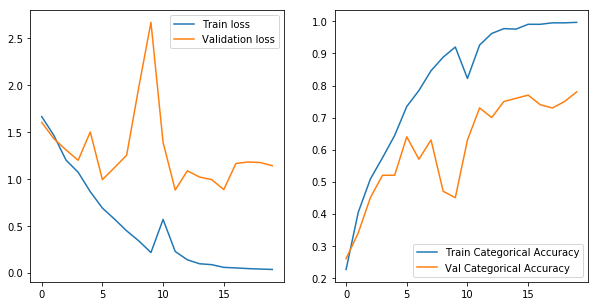

In [7]:
conv2d_lstm7.plot_model_perf(model_22)

### Model 7 (CNN 2D + GRU)

In [8]:
class Model_CNN72d(modelSkeleton):
    def model_define(self):
        """
        """
        model = Sequential()
        model.add(TimeDistributed(Conv2D(16, (3, 3) , padding='same'),
                                  input_shape=(self.frame_ip,self.height,self.width,self.channel)))
        model.add(TimeDistributed(Activation(activations.relu)))
        model.add(TimeDistributed(MaxPooling2D(pool_size=(2,2), padding='SAME',strides=(2,2))))
        
        model.add(TimeDistributed(Conv2D(32, (3, 3) , padding='same')))
        model.add(TimeDistributed(Activation(activations.relu)))
        model.add(TimeDistributed(MaxPooling2D(pool_size=(2,2), padding='SAME',strides=(2,2))))
        
        model.add(TimeDistributed(Conv2D(64, (3, 3) , padding='same')))
        model.add(TimeDistributed(Activation(activations.relu)))
        model.add(TimeDistributed(MaxPooling2D(pool_size=(2,2), padding='SAME',strides=(2,2))))

        model.add(TimeDistributed(Conv2D(128, (3, 3) , padding='same')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(Activation(activations.relu)))
        model.add(TimeDistributed(MaxPooling2D(pool_size=(2,2), padding='SAME',strides=(2,2))))
        model.add(Dropout(0.25))
        
        model.add(TimeDistributed(Flatten()))
        
        model.add(Dense(128,activation='relu'))
        model.add(Dropout(0.25))
        model.add(Dense(64,activation='relu'))
        model.add(Dropout(0.25))
        model.add(GRU(128))
        model.add(Dropout(0.25))
        model.add(Dense(self.no_of_class,activation='softmax'))
        
        model.compile(optimizer=optimizers.Adam(), loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [9]:
conv2d_lstm8 = Model_CNN72d()
conv2d_lstm8.set_dataset_directory()
conv2d_lstm8.setting_conf(100,100, total_frame_per_video = 30, 
                           frame_ip = 25, batch_size = 30, num_of_epochs = 20)
conv2d_lstm8_model = conv2d_lstm8.model_define()
conv2d_lstm8_model.summary()

model_23 = conv2d_lstm8.model_train(conv2d_lstm8_model)

Setting the Dataset Specific Parameter
# training sequences = 663
# validation sequences = 100
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_15 (TimeDis (None, 25, 100, 100, 16)  448       
_________________________________________________________________
time_distributed_16 (TimeDis (None, 25, 100, 100, 16)  0         
_________________________________________________________________
time_distributed_17 (TimeDis (None, 25, 50, 50, 16)    0         
_________________________________________________________________
time_distributed_18 (TimeDis (None, 25, 50, 50, 32)    4640      
_________________________________________________________________
time_distributed_19 (TimeDis (None, 25, 50, 50, 32)    0         
_________________________________________________________________
time_distributed_20 (TimeDis (None, 25, 25, 25, 32)    0         
_______________________________________________

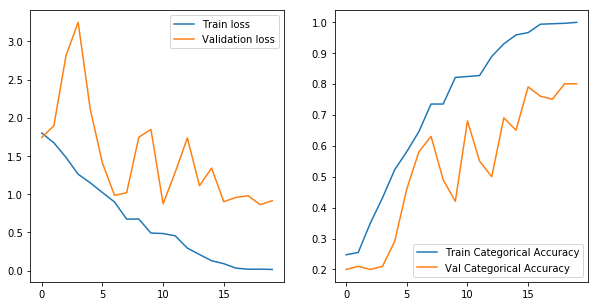

In [10]:
conv2d_lstm8.plot_model_perf(model_23)

### Model 8  (CNN 2D + GRU) Complex Model Based on VGG Architecture

In [3]:
class Model_CNN2d_Complex_Model(modelSkeleton):
    def model_define(self):
        """
        Here the Conv2d architecture is based on the VGG Architecture Based. Then the the GRU is being used 
        and followed by Dense
        """
        model = Sequential()
        model.add(TimeDistributed(Conv2D(64, (3, 3) , padding='same'),
                                  input_shape=(self.frame_ip,self.height,self.width,self.channel)))
        model.add(TimeDistributed(Activation(activations.relu)))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D(pool_size=(2,2), padding='SAME',strides=(2,2))))
        
        model.add(TimeDistributed(Conv2D(128, (3, 3) , padding='same')))
        model.add(TimeDistributed(Activation(activations.relu)))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D(pool_size=(2,2), padding='SAME',strides=(2,2))))
        
        model.add(TimeDistributed(Conv2D(256, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(Conv2D(256, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D(pool_size=(2,2), padding='SAME',strides=(2,2))))
 
        model.add(TimeDistributed(Conv2D(512, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(Conv2D(512, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(Conv2D(512, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D(pool_size=(2,2), padding='SAME',strides=(2,2))))
        
        model.add(TimeDistributed(Flatten()))
        model.add(GRU(32, dropout=0.5,recurrent_dropout=0.5))
        model.add(Dense(1024,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(0.5))

        model.add(Dense(512,activation='relu'))
        model.add(Dropout(0.5))
        
        model.add(Dense(64,activation='relu'))
        model.add(Dropout(0.5))
        model.add(Dense(self.no_of_class,activation='softmax'))
        
        model.compile(optimizer=optimizers.Adam(), loss='categorical_crossentropy', metrics=['categorical_accuracy'])
                  
        return model

In [4]:
conv2d_complex1 = Model_CNN2d_Complex_Model()
conv2d_complex1.set_dataset_directory()
conv2d_complex1.setting_conf(120,120, total_frame_per_video = 30, 
                           frame_ip = 15, batch_size = 20, num_of_epochs = 20)
conv2d_complex1_model = conv2d_complex1.model_define()
conv2d_complex1_model.summary()

modelcomp_1 = conv2d_complex1.model_train(conv2d_complex1_model)

Setting the Dataset Specific Parameter
# training sequences = 663
# validation sequences = 100
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_1 (TimeDist (None, 15, 120, 120, 64)  1792      
_________________________________________________________________
time_distributed_2 (TimeDist (None, 15, 120, 120, 64)  0         
_________________________________________________________________
time_distributed_3 (TimeDist (None, 15, 120, 120, 64)  256       
_________________________________________________________________
time_distributed_4 (TimeDist (None, 15, 60, 60, 64)    0         
_________________________________________________________________
time_distributed_5 (TimeDist (None, 15, 60, 60, 128)   73856     
_________________________________________________________________
time_distributed_6 (TimeDist (None, 15, 60, 60, 128)   0         
_______________________________________________

Epoch 15/20
34/34 [==============================] - 63s 2s/step - loss: 1.6131 - categorical_accuracy: 0.2127 - val_loss: 1.6170 - val_categorical_accuracy: 0.2100

Epoch 00015: saving model to training_models/model_init_2020-05-2415_09_50.323063/model-00015-1.61507-0.20965-1.61697-0.21000.h5
Epoch 16/20
34/34 [==============================] - 63s 2s/step - loss: 1.6324 - categorical_accuracy: 0.2171 - val_loss: 1.6221 - val_categorical_accuracy: 0.1700

Epoch 00016: saving model to training_models/model_init_2020-05-2415_09_50.323063/model-00016-1.63322-0.21418-1.62212-0.17000.h5
Epoch 17/20
34/34 [==============================] - 63s 2s/step - loss: 1.6349 - categorical_accuracy: 0.2355 - val_loss: 1.6160 - val_categorical_accuracy: 0.2100

Epoch 00017: saving model to training_models/model_init_2020-05-2415_09_50.323063/model-00017-1.63627-0.22474-1.61599-0.21000.h5
Epoch 18/20
34/34 [==============================] - 63s 2s/step - loss: 1.5938 - categorical_accuracy: 0.2377 - va

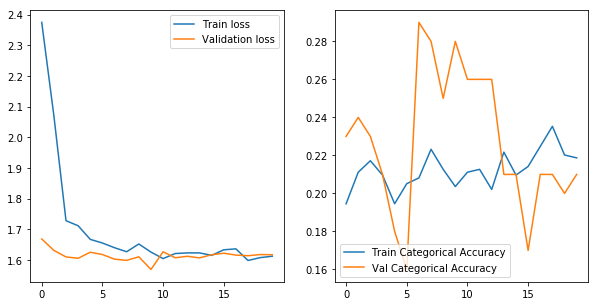

In [7]:
conv2d_complex1.plot_model_perf(modelcomp_1)

### Model 9  (CNN 2D + GRU) Complex Model Based on VGG with Simpler Architecture

In [15]:
class Model_CNN2d_Complex_Model_2(modelSkeletonLessAugmentation):
    def model_define(self):
        """
        Here the Conv2d architecture is based on the VGG Architecture Based, but this is a lighter arcitecture. 
        Then the the GRU is being used and followed by Dense
        """
        model = Sequential()
        model.add(TimeDistributed(Conv2D(16, (3, 3) , padding='same'),
                                  input_shape=(self.frame_ip,self.height,self.width,self.channel)))
        model.add(TimeDistributed(Activation(activations.relu)))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D(pool_size=(3,3), padding='SAME',strides=(2,2))))
        
        model.add(TimeDistributed(Conv2D(64, (3, 3) , padding='same')))
        model.add(TimeDistributed(Activation(activations.relu)))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D(pool_size=(3,3), padding='SAME',strides=(2,2))))
        
        model.add(TimeDistributed(Conv2D(128, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(Conv2D(128, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D(pool_size=(3,3), padding='SAME',strides=(2,2))))
        
        model.add(TimeDistributed(Flatten()))
        model.add(GRU(32, dropout=0.5,recurrent_dropout=0.5))
        model.add(Dense(1024,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(0.5))

        model.add(Dense(512,activation='relu'))
        model.add(Dropout(0.5))
        
        model.add(Dense(64,activation='relu'))
        model.add(Dropout(0.5))
        model.add(Dense(self.no_of_class,activation='softmax'))
        
        model.compile(optimizer=optimizers.Adam(), loss='categorical_crossentropy', metrics=['categorical_accuracy'])
                  
        return model

In [17]:
conv2d_complex2 = Model_CNN2d_Complex_Model_2()
conv2d_complex2.set_dataset_directory()
conv2d_complex2.setting_conf(100,100, total_frame_per_video = 15, 
                           frame_ip = 15, batch_size = 40, num_of_epochs = 10)
conv2d_complex2_model = conv2d_complex2.model_define()
conv2d_complex2_model.summary()

modelcomp_2 = conv2d_complex2.model_train(conv2d_complex2_model, need_augmentation = True)

Setting the Dataset Specific Parameter
# training sequences = 663
# validation sequences = 100
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_84 (TimeDis (None, 15, 100, 100, 16)  448       
_________________________________________________________________
time_distributed_85 (TimeDis (None, 15, 100, 100, 16)  0         
_________________________________________________________________
time_distributed_86 (TimeDis (None, 15, 100, 100, 16)  64        
_________________________________________________________________
time_distributed_87 (TimeDis (None, 15, 50, 50, 16)    0         
_________________________________________________________________
time_distributed_88 (TimeDis (None, 15, 50, 50, 64)    9280      
_________________________________________________________________
time_distributed_89 (TimeDis (None, 15, 50, 50, 64)    0         
_______________________________________________

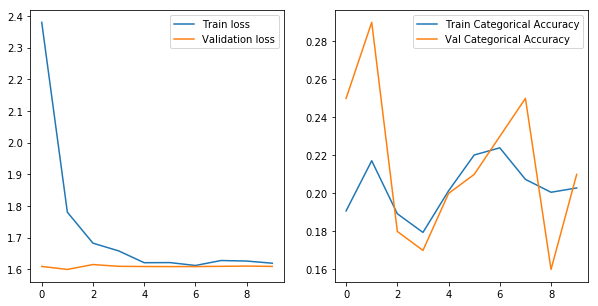

In [20]:
conv2d_complex2.plot_model_perf(modelcomp_2)

### Model 10 (CNN 2D + LSTM) Complex Model Based on VGG

In [25]:
class Model_CNN2d_Complex_Model_3(modelSkeleton):
    def model_define(self):
        """
        Here the Conv2d architecture is based on the VGG Architecture Based. Then the the LSTM is being used 
        and followed by Dense
        """
        model = Sequential()
        model.add(TimeDistributed(Conv2D(64, (3, 3) , padding='same'),
                                  input_shape=(self.frame_ip,self.height,self.width,self.channel)))
        model.add(TimeDistributed(Activation(activations.relu)))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D(pool_size=(2,2), padding='SAME',strides=(2,2))))
        
        model.add(TimeDistributed(Conv2D(128, (3, 3) , padding='same')))
        model.add(TimeDistributed(Activation(activations.relu)))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D(pool_size=(2,2), padding='SAME',strides=(2,2))))
        
        model.add(TimeDistributed(Conv2D(256, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(Conv2D(256, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D(pool_size=(2,2), padding='SAME',strides=(2,2))))
 
        model.add(TimeDistributed(Conv2D(512, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(Conv2D(512, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(Conv2D(512, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D(pool_size=(2,2), padding='SAME',strides=(2,2))))
        
        model.add(TimeDistributed(Flatten()))
        model.add(LSTM(32, return_sequences=True,  dropout=0.5,recurrent_dropout=0.5))
        model.add(LSTM(32, return_sequences=False, dropout=0.5,recurrent_dropout=0.5))
        model.add(Dense(1024,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(0.5))

        model.add(Dense(512,activation='relu'))
        model.add(Dropout(0.5))
        
        model.add(Dense(64,activation='relu'))
        model.add(Dropout(0.5))
        model.add(Dense(self.no_of_class,activation='softmax'))
        
        model.compile(optimizer=optimizers.Adam(), loss='categorical_crossentropy', metrics=['categorical_accuracy'])
                  
        return model

In [26]:
conv2d_complex3 = Model_CNN2d_Complex_Model_3()
conv2d_complex3.set_dataset_directory()
conv2d_complex3.setting_conf(100,100, total_frame_per_video = 30, 
                           frame_ip = 15, batch_size = 20, num_of_epochs = 15)
conv2d_complex3_model = conv2d_complex3.model_define()
conv2d_complex3_model.summary()

modelcomp_3 = conv2d_complex3.model_train(conv2d_complex3_model)

Setting the Dataset Specific Parameter
# training sequences = 663
# validation sequences = 100
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_133 (TimeDi (None, 15, 100, 100, 64)  1792      
_________________________________________________________________
time_distributed_134 (TimeDi (None, 15, 100, 100, 64)  0         
_________________________________________________________________
time_distributed_135 (TimeDi (None, 15, 100, 100, 64)  256       
_________________________________________________________________
time_distributed_136 (TimeDi (None, 15, 50, 50, 64)    0         
_________________________________________________________________
time_distributed_137 (TimeDi (None, 15, 50, 50, 128)   73856     
_________________________________________________________________
time_distributed_138 (TimeDi (None, 15, 50, 50, 128)   0         
_______________________________________________


Epoch 00014: saving model to training_models/model_init_2020-05-2416_10_30.662371/model-00014-1.61458-0.20362-1.60879-0.23000.h5
Epoch 15/15
34/34 [==============================] - 57s 2s/step - loss: 1.6242 - categorical_accuracy: 0.2178 - val_loss: 1.6088 - val_categorical_accuracy: 0.2300

Epoch 00015: saving model to training_models/model_init_2020-05-2416_10_30.662371/model-00015-1.62413-0.22323-1.60881-0.23000.h5


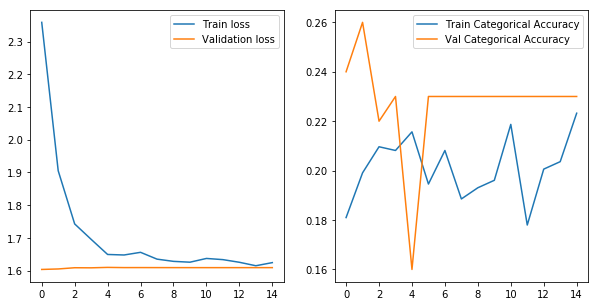

In [28]:
conv2d_complex3.plot_model_perf(modelcomp_3)

### Model 11  (CNN 2D + LSTM) Complex Model Based on VGG + Removing all the regularization layers

In [3]:
class Model_CNN2d_Complex_Model_4(modelSkeleton):
    def model_define(self):
        """
        Here the Conv2d architecture is based on the VGG Architecture Based. Then the the LSTM is being used 
        and followed by Dense
        """
        model = Sequential()
        model.add(TimeDistributed(Conv2D(64, (3, 3) , padding='same'),
                                  input_shape=(self.frame_ip,self.height,self.width,self.channel)))
        model.add(TimeDistributed(Activation(activations.relu)))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D(pool_size=(2,2), padding='SAME',strides=(2,2))))
        
        model.add(TimeDistributed(Conv2D(128, (3, 3) , padding='same')))
        model.add(TimeDistributed(Activation(activations.relu)))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D(pool_size=(2,2), padding='SAME',strides=(2,2))))
        
        model.add(TimeDistributed(Conv2D(256, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(Conv2D(256, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D(pool_size=(2,2), padding='SAME',strides=(2,2))))
 
        model.add(TimeDistributed(Conv2D(512, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(Conv2D(512, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(Conv2D(512, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D(pool_size=(2,2), padding='SAME',strides=(2,2))))
        
        model.add(TimeDistributed(Flatten()))
        model.add(LSTM(32, return_sequences=True))
        model.add(LSTM(32, return_sequences=False))
        model.add(Dense(1024,activation='relu'))
        model.add(BatchNormalization())

        model.add(Dense(512,activation='relu'))
        
        model.add(Dense(64,activation='relu'))
        model.add(Dense(self.no_of_class,activation='softmax'))
        
        model.compile(optimizer=optimizers.Adam(), loss='categorical_crossentropy', metrics=['categorical_accuracy'])
                  
        return model

In [4]:
conv2d_complex4 = Model_CNN2d_Complex_Model_4()
conv2d_complex4.set_dataset_directory()
conv2d_complex4.setting_conf(100,100, total_frame_per_video = 30, 
                           frame_ip = 15, batch_size = 20, num_of_epochs = 10)
conv2d_complex4_model = conv2d_complex4.model_define()
conv2d_complex4_model.summary()

modelcomp_4 = conv2d_complex4.model_train(conv2d_complex4_model)

Setting the Dataset Specific Parameter
# training sequences = 663
# validation sequences = 100
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_1 (TimeDist (None, 15, 100, 100, 64)  1792      
_________________________________________________________________
time_distributed_2 (TimeDist (None, 15, 100, 100, 64)  0         
_________________________________________________________________
time_distributed_3 (TimeDist (None, 15, 100, 100, 64)  256       
_________________________________________________________________
time_distributed_4 (TimeDist (None, 15, 50, 50, 64)    0         
_________________________________________________________________
time_distributed_5 (TimeDist (None, 15, 50, 50, 128)   73856     
_________________________________________________________________
time_distributed_6 (TimeDist (None, 15, 50, 50, 128)   0         
_______________________________________________

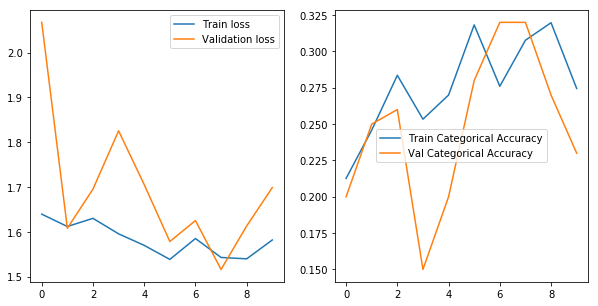

In [5]:
conv2d_complex4.plot_model_perf(modelcomp_4)

#### Conclusion
Even after removing all the regularisation layer model is underfitting, possible reason can be because of the vanishing gradients. So lets try out some different models

### Model 12  (Transfer Learning CNN 2D + LSTM) 

In [7]:
# https://keras.io/api/applications/
# After looking into all the Pre-trained Model, we decided to first start with a model which is light weight and 
# has less number of parameters, so it turns out MobileNet as least number of parameters

class Model_CNN2d_Trans_Learn(modelSkeleton):
    def model_define(self):
        """
        We will use the pretrained weights (from Imagenet) of MobileNet
        We'll add some of our own last layers 
        """
        model = Sequential()
        model.add(TimeDistributed(MobileNetV2(include_top=False), 
                                  input_shape=(self.frame_ip,self.height,self.width,self.channel)))
        # freeze the layers in base model
        for layer in model.layers:
            layer.trainable = False
            
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
       
        model.add(TimeDistributed(Flatten()))
        model.add(LSTM(64))
        model.add(Dense(256,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dense(64,activation='relu'))
        model.add(BatchNormalization())
        
        model.add(Dense(self.no_of_class,activation='softmax'))
        model.compile(optimizer=optimizers.Adam(), loss='categorical_crossentropy', metrics=['categorical_accuracy'])
                  
        return model

In [8]:
conv2d_tl1 = Model_CNN2d_Trans_Learn()
conv2d_tl1.set_dataset_directory()
conv2d_tl1.setting_conf(100,100, total_frame_per_video = 30, 
                           frame_ip = 15, batch_size = 20, num_of_epochs = 10)
conv2d_tl1_model = conv2d_tl1.model_define()
conv2d_tl1_model.summary()

modeltl_1 = conv2d_tl1.model_train(conv2d_tl1_model)

Setting the Dataset Specific Parameter
# training sequences = 663
# validation sequences = 100
9412608/9406464 [==============================] - 2s 0us/step
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_19 (TimeDis (None, 15, 4, 4, 1280)    2257984   
_________________________________________________________________
time_distributed_20 (TimeDis (None, 15, 4, 4, 1280)    5120      
_________________________________________________________________
time_distributed_21 (TimeDis (None, 15, 2, 2, 1280)    0         
_________________________________________________________________
time_distributed_22 (TimeDis (None, 15, 5120)          0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 64)                1327360   
_________________________________________________________________
dense_5 (Dense)              (None, 256)          

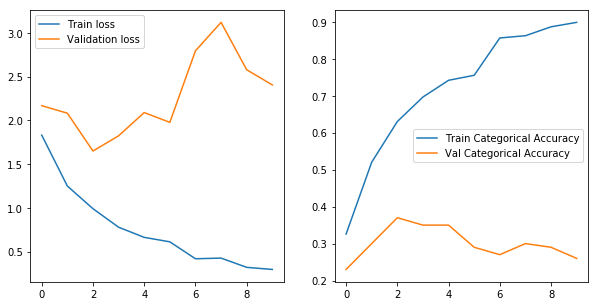

In [9]:
conv2d_tl1.plot_model_perf(modeltl_1)

### Model 13  (Transfer Learning CNN 2D + LSTM + Training weights) 

In [11]:
# As it can be seen above model is overfitting but the validation accuracy is very less, lets try to train the weights
# https://keras.io/api/applications/
# After looking into all the Pre-trained Model, we decided to first start with a model which is light weight and 
# has less number of parameters, so it turns out MobileNet as least number of parameters

class Model_CNN2d_Trans_Learn2(modelSkeleton):
    def model_define(self):
        """
        We will use the pretrained weights (from Imagenet) of MobileNet
        We'll add some of our own last layers 
        """
        model = Sequential()
        model.add(TimeDistributed(MobileNetV2(include_top=False), 
                                  input_shape=(self.frame_ip,self.height,self.width,self.channel)))
#         for layer in model.layers:
#             layer.trainable = True
            
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
       
        model.add(TimeDistributed(Flatten()))
        model.add(LSTM(64))
        model.add(Dense(256,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dense(64,activation='relu'))
        model.add(BatchNormalization())
        
        model.add(Dense(self.no_of_class,activation='softmax'))
        model.compile(optimizer=optimizers.Adam(), loss='categorical_crossentropy', metrics=['categorical_accuracy'])
                  
        return model

In [12]:
conv2d_tl2 = Model_CNN2d_Trans_Learn2()
conv2d_tl2.set_dataset_directory()
conv2d_tl2.setting_conf(100,100, total_frame_per_video = 30, 
                           frame_ip = 15, batch_size = 20, num_of_epochs = 10)
conv2d_tl2_model = conv2d_tl2.model_define()
conv2d_tl2_model.summary()

modeltl_2 = conv2d_tl2.model_train(conv2d_tl2_model)

Setting the Dataset Specific Parameter
# training sequences = 663
# validation sequences = 100
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_23 (TimeDis (None, 15, 4, 4, 1280)    2257984   
_________________________________________________________________
time_distributed_24 (TimeDis (None, 15, 4, 4, 1280)    5120      
_________________________________________________________________
time_distributed_25 (TimeDis (None, 15, 2, 2, 1280)    0         
_________________________________________________________________
time_distributed_26 (TimeDis (None, 15, 5120)          0         
_________________________________________________________________
lstm_4 (LSTM)                (None, 64)                1327360   
_________________________________________________________________
dense_8 (Dense)              (None, 256)               16640     
_______________________________________________

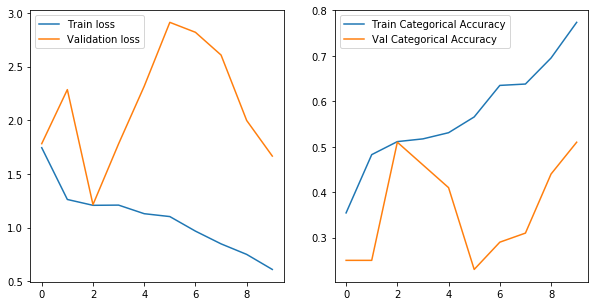

In [13]:
conv2d_tl2.plot_model_perf(modeltl_2)

### Model 14  (Transfer Learning CNN 2D + LSTM + Training weights + Removing Batch Normalization) 

In [15]:
# As it can be seen above model is overfitting but the validation accuracy is less stable, lets try to train the weights
# and lets remove the batch normalization from the last Dense Layers
# https://keras.io/api/applications/
# After looking into all the Pre-trained Model, we decided to first start with a model which is light weight and 
# has less number of parameters, so it turns out MobileNet as least number of parameters

class Model_CNN2d_Trans_Learn3(modelSkeleton):
    def model_define(self):
        """
        We will use the pretrained weights (from Imagenet) of MobileNet
        We'll add some of our own last layers 
        """
        model = Sequential()
        model.add(TimeDistributed(MobileNetV2(include_top=False), 
                                  input_shape=(self.frame_ip,self.height,self.width,self.channel)))
#         for layer in model.layers:
#             layer.trainable = True
            
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
       
        model.add(TimeDistributed(Flatten()))
        model.add(LSTM(64))
        model.add(Dense(256,activation='relu'))
        model.add(Dense(64,activation='relu'))
        
        model.add(Dense(self.no_of_class,activation='softmax'))
        model.compile(optimizer=optimizers.Adam(), loss='categorical_crossentropy', metrics=['categorical_accuracy'])
                  
        return model

In [16]:
# lets increase the frame inputs and the num_of_epochs
conv2d_tl3 = Model_CNN2d_Trans_Learn3()
conv2d_tl3.set_dataset_directory()
conv2d_tl3.setting_conf(100,100, total_frame_per_video = 30, 
                           frame_ip = 20, batch_size = 20, num_of_epochs = 15)
conv2d_tl3_model = conv2d_tl3.model_define()
conv2d_tl3_model.summary()

modeltl_3 = conv2d_tl3.model_train(conv2d_tl3_model)

Setting the Dataset Specific Parameter
# training sequences = 663
# validation sequences = 100
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_27 (TimeDis (None, 20, 4, 4, 1280)    2257984   
_________________________________________________________________
time_distributed_28 (TimeDis (None, 20, 4, 4, 1280)    5120      
_________________________________________________________________
time_distributed_29 (TimeDis (None, 20, 2, 2, 1280)    0         
_________________________________________________________________
time_distributed_30 (TimeDis (None, 20, 5120)          0         
_________________________________________________________________
lstm_5 (LSTM)                (None, 64)                1327360   
_________________________________________________________________
dense_11 (Dense)             (None, 256)               16640     
_______________________________________________

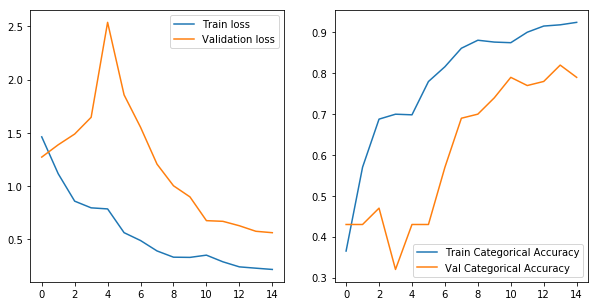

In [17]:
conv2d_tl3.plot_model_perf(modeltl_3)

In [23]:
# lets try with augmentation and less batch size
# Lets see wether the model performance improves or not
# Reducing image because of OOM error
conv2d_tl4 = Model_CNN2d_Trans_Learn3()
conv2d_tl4.set_dataset_directory()
conv2d_tl4.setting_conf(80,80, total_frame_per_video = 30, 
                           frame_ip = 15, batch_size = 10, num_of_epochs = 15)
conv2d_tl4_model = conv2d_tl4.model_define()
conv2d_tl4_model.summary()

modeltl_4 = conv2d_tl4.model_train(conv2d_tl4_model, need_augmentation = True)

Setting the Dataset Specific Parameter
# training sequences = 663
# validation sequences = 100
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_51 (TimeDis (None, 15, 3, 3, 1280)    2257984   
_________________________________________________________________
time_distributed_52 (TimeDis (None, 15, 3, 3, 1280)    5120      
_________________________________________________________________
time_distributed_53 (TimeDis (None, 15, 1, 1, 1280)    0         
_________________________________________________________________
time_distributed_54 (TimeDis (None, 15, 1280)          0         
_________________________________________________________________
lstm_11 (LSTM)               (None, 64)                344320    
_________________________________________________________________
dense_29 (Dense)             (None, 256)               16640     
_______________________________________________

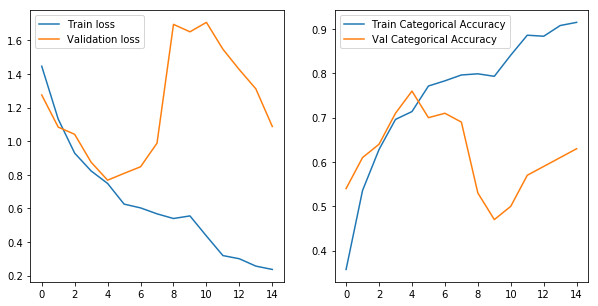

In [24]:
conv2d_tl4.plot_model_perf(modeltl_4)

### Model 15  (Transfer Learning CNN 2D + GRU + Training weights) 

In [27]:
# Reduce the number of parameter, because in the above mode, the model was overfitting but the validation accuracy is not improving
class Model_CNN2d_Trans_Learn4(modelSkeleton):
    def model_define(self):
        """
        We will use the pretrained weights (from Imagenet) of MobileNet
        We'll add some of our own last layers 
        """
        model = Sequential()
        model.add(TimeDistributed(MobileNetV2(include_top=False), 
                                  input_shape=(self.frame_ip,self.height,self.width,self.channel)))
#         for layer in model.layers:
#             layer.trainable = True
            
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
       
        model.add(TimeDistributed(Flatten()))
        model.add(GRU(128))
        model.add(Dense(256,activation='relu'))
        model.add(Dense(64,activation='relu'))
        
        model.add(Dense(self.no_of_class,activation='softmax'))
        model.compile(optimizer=optimizers.Adam(), loss='categorical_crossentropy', metrics=['categorical_accuracy'])
                  
        return model

In [29]:
conv2d_tl5 = Model_CNN2d_Trans_Learn4()
conv2d_tl5.set_dataset_directory()
conv2d_tl5.setting_conf(100,100, total_frame_per_video = 30, 
                           frame_ip = 20, batch_size = 10, num_of_epochs = 15)
conv2d_tl5_model = conv2d_tl5.model_define()
conv2d_tl5_model.summary()

modeltl_5 = conv2d_tl5.model_train(conv2d_tl5_model)

Setting the Dataset Specific Parameter
# training sequences = 663
# validation sequences = 100
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_63 (TimeDis (None, 20, 4, 4, 1280)    2257984   
_________________________________________________________________
time_distributed_64 (TimeDis (None, 20, 4, 4, 1280)    5120      
_________________________________________________________________
time_distributed_65 (TimeDis (None, 20, 2, 2, 1280)    0         
_________________________________________________________________
time_distributed_66 (TimeDis (None, 20, 5120)          0         
_________________________________________________________________
gru_2 (GRU)                  (None, 128)               2015616   
_________________________________________________________________
dense_38 (Dense)             (None, 256)               33024     
_______________________________________________

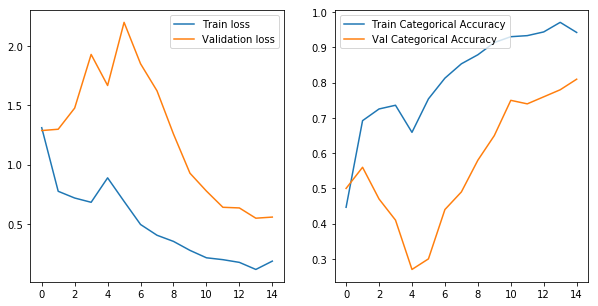

In [30]:
conv2d_tl5.plot_model_perf(modeltl_5)

### Model 16  (Transfer Learning CNN 2D + GRU + Training weights + Augmentation) 

In [4]:
class Model_CNN2d_Trans_Lear5(modelSkeletonLessAugmentation):
    def model_define(self):
        """
        We will use the pretrained weights (from Imagenet) of MobileNet
        We'll add some of our own last layers 
        """
        model = Sequential()
        model.add(TimeDistributed(MobileNetV2(include_top=False), 
                                  input_shape=(self.frame_ip,self.height,self.width,self.channel)))
#         for layer in model.layers:
#             layer.trainable = True
            
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
       
        model.add(TimeDistributed(Flatten()))
        model.add(GRU(128))
        model.add(Dense(256,activation='relu'))
        model.add(Dense(64,activation='relu'))
        
        model.add(Dense(self.no_of_class,activation='softmax'))
        model.compile(optimizer=optimizers.Adam(), loss='categorical_crossentropy', metrics=['categorical_accuracy'])
                  
        return model

In [5]:
conv2d_tl6 = Model_CNN2d_Trans_Lear5()
conv2d_tl6.set_dataset_directory()
conv2d_tl6.setting_conf(100,100, total_frame_per_video = 30, 
                           frame_ip = 15, batch_size = 10, num_of_epochs = 25)
conv2d_tl6_model = conv2d_tl6.model_define()
conv2d_tl6_model.summary()

modeltl_6 = conv2d_tl6.model_train(conv2d_tl6_model, need_augmentation = True)

Setting the Dataset Specific Parameter
# training sequences = 663
# validation sequences = 100
9412608/9406464 [==============================] - 2s 0us/step
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_1 (TimeDist (None, 15, 4, 4, 1280)    2257984   
_________________________________________________________________
time_distributed_2 (TimeDist (None, 15, 4, 4, 1280)    5120      
_________________________________________________________________
time_distributed_3 (TimeDist (None, 15, 2, 2, 1280)    0         
_________________________________________________________________
time_distributed_4 (TimeDist (None, 15, 5120)          0         
_________________________________________________________________
gru_1 (GRU)                  (None, 128)               2015616   
_________________________________________________________________
dense_1 (Dense)              (None, 256)          


Epoch 00022: saving model to training_models/model_init_2020-05-2505_59_59.888362/model-00022-0.17585-0.93213-0.44600-0.88000.h5
Epoch 23/25
67/67 [==============================] - 98s 1s/step - loss: 0.1803 - categorical_accuracy: 0.9269 - val_loss: 0.5536 - val_categorical_accuracy: 0.8000

Epoch 00023: saving model to training_models/model_init_2020-05-2505_59_59.888362/model-00023-0.18145-0.92609-0.55357-0.80000.h5
Epoch 24/25
67/67 [==============================] - 97s 1s/step - loss: 0.1589 - categorical_accuracy: 0.9386 - val_loss: 0.4280 - val_categorical_accuracy: 0.8800

Epoch 00024: saving model to training_models/model_init_2020-05-2505_59_59.888362/model-00024-0.15493-0.93967-0.42797-0.88000.h5
Epoch 25/25
67/67 [==============================] - 98s 1s/step - loss: 0.1889 - categorical_accuracy: 0.9329 - val_loss: 0.7609 - val_categorical_accuracy: 0.7700

Epoch 00025: saving model to training_models/model_init_2020-05-2505_59_59.888362/model-00025-0.17361-0.93741-0.76

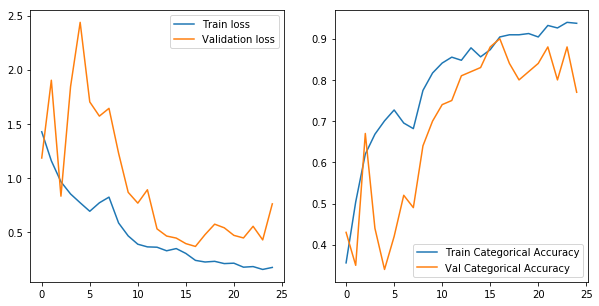

In [6]:
conv2d_tl6.plot_model_perf(modeltl_6)

### Model 17  (Transfer Learning CNN 2D ( Xception ) + GRU + Training weights + Augmentation) 

In [15]:
class Model_CNN2d_Trans_Lear6(modelSkeletonLessAugmentation):
    def model_define(self):
        """
        We will use the pretrained weights (from Imagenet) of Xception
        We'll add some of our own last layers 
        """
        model = Sequential()
        model.add(TimeDistributed(Xception(include_top=False), 
                                  input_shape=(self.frame_ip,self.height,self.width,self.channel)))
#         for layer in model.layers:
#             layer.trainable = True
            
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
       
        model.add(TimeDistributed(Flatten()))
        model.add(GRU(128))
        model.add(Dense(256,activation='relu'))
        model.add(Dense(64,activation='relu'))
        
        model.add(Dense(self.no_of_class,activation='softmax'))
        model.compile(optimizer=optimizers.Adam(), loss='categorical_crossentropy', metrics=['categorical_accuracy'])
                  
        return model

In [16]:
conv2d_tl7 = Model_CNN2d_Trans_Lear6()
conv2d_tl7.set_dataset_directory()
conv2d_tl7.setting_conf(80,80, total_frame_per_video = 15, 
                           frame_ip = 15, batch_size = 10, num_of_epochs = 25)
conv2d_tl7_model = conv2d_tl7.model_define()
conv2d_tl7_model.summary()

modeltl_7 = conv2d_tl7.model_train(conv2d_tl7_model, need_augmentation = True)

Setting the Dataset Specific Parameter
# training sequences = 663
# validation sequences = 100
83689472/83683744 [==============================] - 6s 0us/step
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_17 (TimeDis (None, 15, 3, 3, 2048)    20861480  
_________________________________________________________________
time_distributed_18 (TimeDis (None, 15, 3, 3, 2048)    8192      
_________________________________________________________________
time_distributed_19 (TimeDis (None, 15, 1, 1, 2048)    0         
_________________________________________________________________
time_distributed_20 (TimeDis (None, 15, 2048)          0         
_________________________________________________________________
gru_5 (GRU)                  (None, 128)               835968    
_________________________________________________________________
dense_13 (Dense)             (None, 256)        


Epoch 00022: saving model to training_models/model_init_2020-05-2507_15_58.331229/model-00022-0.05372-0.98492-0.62092-0.85000.h5
Epoch 23/25
67/67 [==============================] - 109s 2s/step - loss: 0.0632 - categorical_accuracy: 0.9821 - val_loss: 0.6105 - val_categorical_accuracy: 0.8400

Epoch 00023: saving model to training_models/model_init_2020-05-2507_15_58.331229/model-00023-0.06343-0.98190-0.61051-0.84000.h5
Epoch 24/25
67/67 [==============================] - 110s 2s/step - loss: 0.0584 - categorical_accuracy: 0.9839 - val_loss: 0.5774 - val_categorical_accuracy: 0.8600

Epoch 00024: saving model to training_models/model_init_2020-05-2507_15_58.331229/model-00024-0.04568-0.98718-0.57743-0.86000.h5
Epoch 25/25
67/67 [==============================] - 110s 2s/step - loss: 0.0317 - categorical_accuracy: 0.9918 - val_loss: 0.6195 - val_categorical_accuracy: 0.8400

Epoch 00025: saving model to training_models/model_init_2020-05-2507_15_58.331229/model-00025-0.03135-0.99170-0

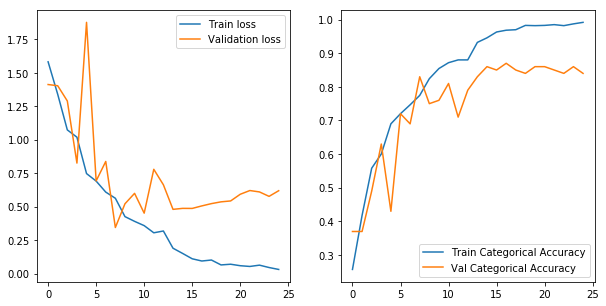

In [17]:
conv2d_tl7.plot_model_perf(modeltl_7)

#### Conclusion
As it can be seen when we used **Xception**, the validation accuracy is not better than **MobileNet** and the validation accuracy is hitting the plateau, till the last epoch and also the loss for **Xception** was significantly higher than **MobileNet**. Model size were also pretty heavy for MobileNet it is 50 MB and for Xception is 200+ MB

### Model 18  (Transfer Learning CNN 2D ( ResNet ) + GRU + Training weights + Augmentation) 

In [36]:
class Model_CNN2d_Trans_Lear7(modelSkeletonLessAugmentation):
    def model_define(self):
        """
        We will use the pretrained weights (from Imagenet) of ResNet
        We'll add some of our own last layers 
        """
        model = Sequential()
        model.add(TimeDistributed(ResNet50(include_top=False), 
                                  input_shape=(self.frame_ip,self.height,self.width,self.channel)))
#         for layer in model.layers:
#             layer.trainable = True
            
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
       
        model.add(TimeDistributed(Flatten()))
        model.add(GRU(128))
        model.add(Dense(256,activation='relu'))
        model.add(Dense(64,activation='relu'))
        
        model.add(Dense(self.no_of_class,activation='softmax'))
        model.compile(optimizer=optimizers.Adam(), loss='categorical_crossentropy', metrics=['categorical_accuracy'])
                  
        return model

In [37]:
conv2d_tl8 = Model_CNN2d_Trans_Lear7()
conv2d_tl8.set_dataset_directory()
conv2d_tl8.setting_conf(80,80, total_frame_per_video = 15, 
                           frame_ip = 15, batch_size = 10, num_of_epochs = 25)
conv2d_tl8_model = conv2d_tl8.model_define()
conv2d_tl8_model.summary()

modeltl_8 = conv2d_tl8.model_train(conv2d_tl8_model, need_augmentation = True)

Setting the Dataset Specific Parameter
# training sequences = 663
# validation sequences = 100
94658560/94653016 [==============================] - 7s 0us/step
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_31 (TimeDis (None, 15, 3, 3, 2048)    23587712  
_________________________________________________________________
time_distributed_32 (TimeDis (None, 15, 3, 3, 2048)    8192      
_________________________________________________________________
time_distributed_33 (TimeDis (None, 15, 1, 1, 2048)    0         
_________________________________________________________________
time_distributed_34 (TimeDis (None, 15, 2048)          0         
_________________________________________________________________
gru_7 (GRU)                  (None, 128)               835968    
_________________________________________________________________
dense_19 (Dense)             (None, 256)        

Epoch 23/25
67/67 [==============================] - 98s 1s/step - loss: 0.0331 - categorical_accuracy: 0.9931 - val_loss: 0.7092 - val_categorical_accuracy: 0.7900

Epoch 00023: saving model to training_models/model_init_2020-05-2509_23_48.718033/model-00023-0.03108-0.99472-0.70915-0.79000.h5
Epoch 24/25
67/67 [==============================] - 98s 1s/step - loss: 0.0288 - categorical_accuracy: 0.9963 - val_loss: 0.6717 - val_categorical_accuracy: 0.8000

Epoch 00024: saving model to training_models/model_init_2020-05-2509_23_48.718033/model-00024-0.02796-0.99623-0.67169-0.80000.h5
Epoch 25/25
67/67 [==============================] - 99s 1s/step - loss: 0.0230 - categorical_accuracy: 0.9978 - val_loss: 0.7288 - val_categorical_accuracy: 0.7900

Epoch 00025: saving model to training_models/model_init_2020-05-2509_23_48.718033/model-00025-0.02263-0.99774-0.72878-0.79000.h5


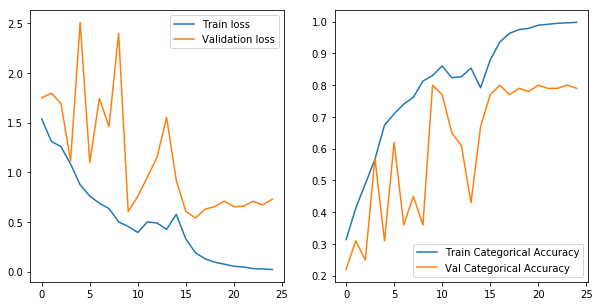

In [38]:
conv2d_tl8.plot_model_perf(modeltl_8)

#### Conclusion
As it can be seen when we used **Resnet50**, the validation accuracy is not better than **MobileNet** and the validation accuracy is hitting the plateau, till the last epoch and also the loss for **Resnet50** was significantly higher than **MobileNet**, and the model has already overfitten. Model size were also pretty heavy for MobileNet it is 50 MB and for Resnet50 is 250+ MB

### Lets load the model and Test 

In [45]:
# For CNN 3D, lets load the Model and check the models Performance
model = load_model('model-00020-0.43257-0.82428-0.49072-0.82000.h5')

conv3d_9 = Model_CNN9()
conv3d_9.set_dataset_directory()
conv3d_9.setting_conf(100,100, total_frame_per_video = 30, 
                           frame_ip = 15, batch_size = 5, num_of_epochs = 1)
g=conv3d_9.generator(conv3d_9.val_path,conv3d_9.val_doc)
batch_data, batch_labels=next(g)

print("Lets check the Batch Labels")
batch_labels

Setting the Dataset Specific Parameter
# training sequences = 663
# validation sequences = 100
Source path =  val ; batch size = 5
Lets check the Batch Labels


array([[0., 0., 0., 0., 1.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1.]])

In [47]:
np.argmax(model.predict(batch_data),axis = 1)

array([4, 3, 4, 0, 4])

**Conclusion**: 
Expected Label and Output Labels are same for Conv3D Model

In [18]:
# For CNN 2D MobileNet, lets load the Model and check the models Performance
model = load_model('model-00022-0.17585-0.93213-0.44600-0.88000.h5')

conv2d_tl6 = Model_CNN2d_Trans_Lear5()
conv2d_tl6.set_dataset_directory()
conv2d_tl6.setting_conf(100,100, total_frame_per_video = 30, 
                           frame_ip = 15, batch_size = 5, num_of_epochs = 1)

Setting the Dataset Specific Parameter
# training sequences = 663
# validation sequences = 100


In [19]:
g=conv2d_tl6.generator(conv2d_tl6.val_path,conv2d_tl6.val_doc)
batch_data, batch_labels=next(g)

print("Lets check the Batch Labels")
batch_labels

Source path =  val ; batch size = 5
Lets check the Batch Labels


array([[0., 0., 0., 0., 1.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0.]])

In [20]:
np.argmax(model.predict(batch_data),axis = 1)

array([4, 3, 4, 1, 2])

**Conclusion**: 
Expected Label and Output Labels are nearly same for Conv2D Model